# Import Modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil

from matplotlib import ticker
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import dbscan
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils._testing import ignore_warnings
from tabulate import tabulate

%matplotlib inline


In [2]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)

# Load and Add Data

In [3]:
df = pd.read_excel('marketing_campaign.xlsx', parse_dates=['Dt_Customer'])

In [4]:
# add an age column
year = np.datetime64('now').astype('datetime64[Y]').astype(int) + 1970
df['Age'] = year - df['Year_Birth']

In [5]:
# add a tenure column (in days)
df['Tenure'] = np.datetime64('now').astype('datetime64[D]') - df['Dt_Customer']

## Inspect Data

In [6]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   
3  2014-02-10       26        11          4               20               10   
4  2014-01-19       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  Age    Tenure  
0              3         11         1   65 3713 days  
1              3         11         0   68 3163 days  
2              3         11         0   57 3362 days  
3              3         11         0   38 3189 days  
4              3         11         0   41 3211 days  

[5 rows x 31 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   ID                   2240 non-null   int64          
 1   Year_Birth           2240 non-null   int64          
 2   Education            2240 non-null   object         
 3   Marital_Status       2240 non-null   object         
 4   Income               2216 non-null   float64        
 5   Kidhome              2240 non-null   int64          
 6   Teenhome             2240 non-null   int64          
 7   Dt_Customer          2240 non-null   datetime64[ns] 
 8   Recency              2240 non-null   int64          
 9   MntWines             2240 non-null   int64          
 10  MntFruits            2240 non-null   int64          
 11  MntMeatProducts      2240 non-null   int64          
 12  MntFishProducts      2240 non-null   int64          
 13  MntSweetProducts  

Only the Income columnn contains null values, which we will fill with 0 later. The columns' descriptions are as follows:

| Syntax | Description |
| ----------- | ----------- |
| **People** |
| ID | Customer's unique identifier |
| Year_Birth | Customer's birth year |
| Education | Customer's education level |
| Marital_Status | Customer's marital status |
| Income | Customer's yearly household income |
| Kidhome | Number of children in customer's household |
| Teenhome | Number of teenagers in customer's household |
| Dt_Customer | Date of customer's enrollment with the company |
| Recency | Number of days since customer's last purchase |
| Complain | 1 if the customer complained in the last 2 years, 0 otherwise |
| **Products** |
| MntWines | Amount spent on wine in last 2 years |
| MntFruits | Amount spent on fruits in last 2 years |
| MntMeatProducts | Amount spent on meat in last 2 years |
| MntFishProducts | Amount spent on fish in last 2 years |
| MntSweetProducts | Amount spent on sweets in last 2 years |
| MntGoldProds | Amount spent on gold in last 2 years |
| **Promotion** |
| NumDealsPurchases | Number of purchases made with a discount |
| AcceptedCmp1 | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| AcceptedCmp2 | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| AcceptedCmp3 | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| AcceptedCmp4 | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| AcceptedCmp5 | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| Response | 1 if customer accepted the offer in the last campaign, 0 otherwise |
| **Place** |
| NumWebPurchases | Number of purchases made through the company’s website |
| NumCatalogPurchases | Number of purchases made using a catalogue |
| NumStorePurchases | Number of purchases made directly in stores |
| NumWebVisitsMonth | Number of visits to company’s website in the last month |
| **Extra** |
| Age | Customer Age |
| Tenure | Number of days since this customer enrolled |

In [8]:
df.describe(include='all', datetime_is_numeric=True)

ID   Year_Birth   Education Marital_Status         Income  \
count    2240.000000  2240.000000        2240           2240    2216.000000   
unique           NaN          NaN           5              8            NaN   
top              NaN          NaN  Graduation        Married            NaN   
freq             NaN          NaN        1127            864            NaN   
mean     5592.159821  1968.805804         NaN            NaN   52247.251354   
min         0.000000  1893.000000         NaN            NaN    1730.000000   
25%      2828.250000  1959.000000         NaN            NaN   35303.000000   
50%      5458.500000  1970.000000         NaN            NaN   51381.500000   
75%      8427.750000  1977.000000         NaN            NaN   68522.000000   
max     11191.000000  1996.000000         NaN            NaN  666666.000000   
std      3246.662198    11.984069         NaN            NaN   25173.076661   

            Kidhome     Teenhome                    Dt_Customer      Recency  \
count   2240.000000  2240.000000                           2240  2240.000000   
unique          NaN          NaN                            NaN          NaN   
top             NaN          NaN                            NaN          NaN   
freq            NaN          NaN                            NaN          NaN   
mean       0.444196     0.506250  2013-07-10 10:01:42.857142784    49.109375   
min        0.000000     0.000000            2012-07-30 00:00:00     0.000000   
25%        0.000000     0.000000            2013-01-16 00:00:00    24.000000   
50%        0.000000     0.000000            2013-07-08 12:00:00    49.000000   
75%        1.000000     1.000000            2013-12-30 06:00:00    74.000000   
max        2.000000     2.000000            2014-06-29 00:00:00    99.000000   
std        0.538398     0.544538                            NaN    28.962453   

           MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
count   2240.000000  2240.000000      2240.000000      2240.000000   
unique          NaN          NaN              NaN              NaN   
top             NaN          NaN              NaN              NaN   
freq            NaN          NaN              NaN              NaN   
mean     303.935714    26.302232       166.950000        37.525446   
min        0.000000     0.000000         0.000000         0.000000   
25%       23.750000     1.000000        16.000000         3.000000   
50%      173.500000     8.000000        67.000000        12.000000   
75%      504.250000    33.000000       232.000000        50.000000   
max     1493.000000   199.000000      1725.000000       259.000000   
std      336.597393    39.773434       225.715373        54.628979   

        MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
count        2240.000000   2240.000000        2240.000000      2240.000000   
unique               NaN           NaN                NaN              NaN   
top                  NaN           NaN                NaN              NaN   
freq                 NaN           NaN                NaN              NaN   
mean           27.062946     44.021875           2.325000         4.084821   
min             0.000000      0.000000           0.000000         0.000000   
25%             1.000000      9.000000           1.000000         2.000000   
50%             8.000000     24.000000           2.000000         4.000000   
75%            33.000000     56.000000           3.000000         6.000000   
max           263.000000    362.000000          15.000000        27.000000   
std            41.280498     52.167439           1.932238         2.778714   

        NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
count           2240.000000        2240.000000        2240.000000   
unique                  NaN                NaN                NaN   
top                     NaN                NaN                NaN   
freq                    NaN                NaN        

In [9]:
# get customers that are really old
df[(df['Age'] > 90)]

ID  Year_Birth Education Marital_Status   Income  Kidhome  Teenhome  \
192   7829        1900  2n Cycle       Divorced  36640.0        1         0   
239  11004        1893  2n Cycle         Single  60182.0        0         1   
339   1150        1899       PhD       Together  83532.0        0         0   

    Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
192  2013-09-26       99        15          6                8   
239  2014-05-17       23         8          0                5   
339  2013-09-26       36       755        144              562   

     MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
192                7                 4            25                  1   
239                7                 0             2                  1   
339              104                64           224                  1   

     NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
192                2                    1                  2   
239                1                    0                  2   
339                4                    6                  4   

     NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
192                  5             0             0             0   
239                  4             0             0             0   
339                  1             0             0             1   

     AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  \
192             0             0         1              3         11         0   
239             0             0         0              3         11         0   
339             0             0         0              3         11         0   

     Age    Tenure  
192  122 3326 days  
239  129 3093 days  
339  123 3326 days  

[3 rows x 31 columns]

## Fill NaNs

In [10]:
# fill empty income values with 0
df['Income'].fillna(0, inplace=True)

## Remove Outliers

In [ ]:
# customers born before 1920 or have an income higher than 600,000
df[(df['Year_Birth'] <= 1920) | (df['Income'] > 600000)]

ID  Year_Birth   Education Marital_Status    Income  Kidhome  \
192    7829        1900    2n Cycle       Divorced   36640.0        1   
239   11004        1893    2n Cycle         Single   60182.0        0   
339    1150        1899         PhD       Together   83532.0        0   
2233   9432        1977  Graduation       Together  666666.0        1   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
192          0  2013-09-26       99        15          6                8   
239          1  2014-05-17       23         8          0                5   
339          0  2013-09-26       36       755        144              562   
2233         0  2013-06-02       23         9         14               18   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
192                 7                 4            25                  1   
239                 7                 0             2                  1   
339               104                64           224                  1   
2233                8                 1            12                  4   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
192                 2                    1                  2   
239                 1                    0                  2   
339                 4                    6                  4   
2233                3                    1                  3   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
192                   5             0             0             0   
239                   4             0             0             0   
339                   1             0             0             1   
2233                  6             0             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  \
192              0             0         1              3         11   
239              0             0         0              3         11   
339              0             0         0              3         11   
2233             0             0         0              3         11   

      Response  Age    Tenure  
192          0  122 3325 days  
239          0  129 3092 days  
339          0  123 3325 days  
2233         0   45 3441 days  

[4 rows x 31 columns]

In [15]:
# customers born before 1920 or have an income higher than 600,000
df.drop(df[(df['Year_Birth'] <= 1920) | (df['Income'] > 600000)].index, inplace=True)
df.reindex()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
0            0  2012-09-04       58       635         88              546   
1            1  2014-03-08       38        11          1                6   
2            0  2013-08-21       26       426         49              127   
3            0  2014-02-10       26        11          4               20   
4            0  2014-01-19       94       173         43              118   
...        ...         ...      ...       ...        ...              ...   
2235         1  2013-06-13       46       709         43              182   
2236         1  2014-06-10       56       406          0               30   
2237         0  2014-01-25       91       908         48              217   
2238         1  2014-01-24        8       428         30              214   
2239         1  2012-10-15       40        84          3               61   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0                 172                88            88                  3   
1                   2                 1             6                  2   
2                 111                21            42                  1   
3                  10                 3             5                  2   
4                  46                27            15                  5   
...               ...               ...           ...                ...   
2235               42               118           247                  2   
2236                0                 0             8                  7   
2237               32                12            24                  1   
2238               80                30            61                  2   
2239                2                 1            21                  3   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                   8                   10                  4   
1                   1                    1                  2   
2                   8                    2                 10   
3                   2                    0                  4   
4                   5                    3                  6   
...               ...                  ...                ...   
2235                9                    3                  4   
2236                8                    2                  5   
2237                2                    3                 13   
2238                6                    5                 10   
2239                3                    1                  4   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
0                     7             0             0             0   
1                     5             0             0             0   
2                     4             0             0             0   
3                     6             0             0             0   
4                     5             0             0             0   
...                 ...           ...           ...           ...   
2235                  5             0     

# Data Visualization

In [16]:
# create a new dataframe copy for use with the correlation heatmap alone
df_corr = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_corr.columns if df_corr[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_corr[cat_cols] = oe.fit_transform(df_corr[cat_cols])
df_corr.head(3)

# df[cat_cols].dtypes

['Education', 'Marital_Status']


ID  Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957        2.0             4.0  58138.0        0         0   
1  2174        1954        2.0             4.0  46344.0        1         1   
2  4141        1965        2.0             5.0  71613.0        0         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  Age    Tenure  
0              3         11         1   65 3713 days  
1              3         11         0   68 3163 days  
2              3         11         0   57 3362 days  

[3 rows x 31 columns]

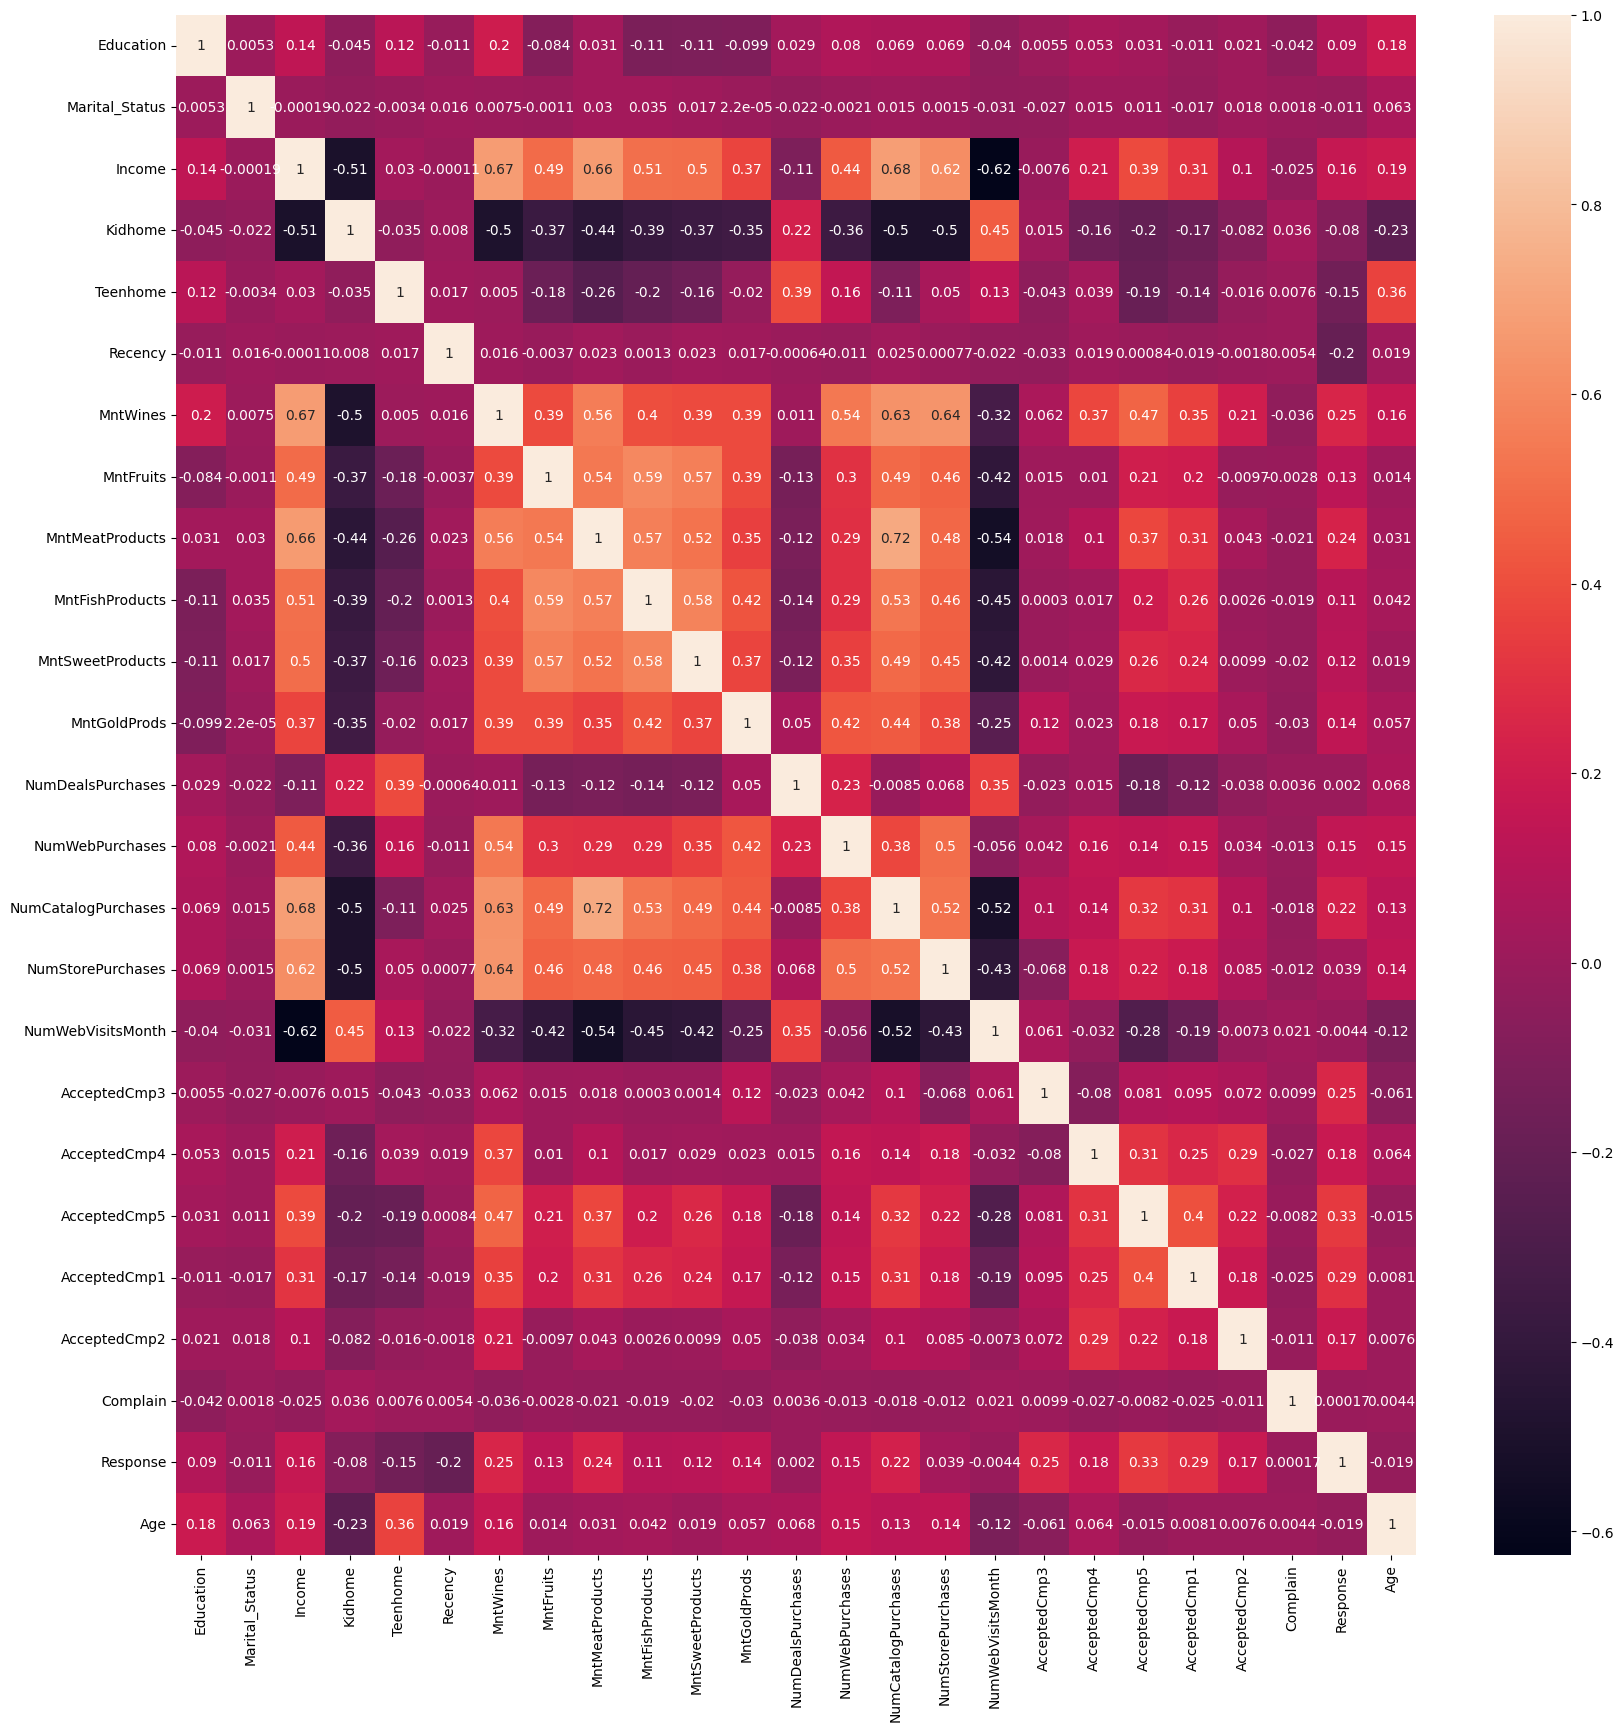

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(df_corr.drop(['ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Year_Birth'], axis=1).corr(
    numeric_only=True), annot=True)

Text(0, 0.5, 'Number of Customers')

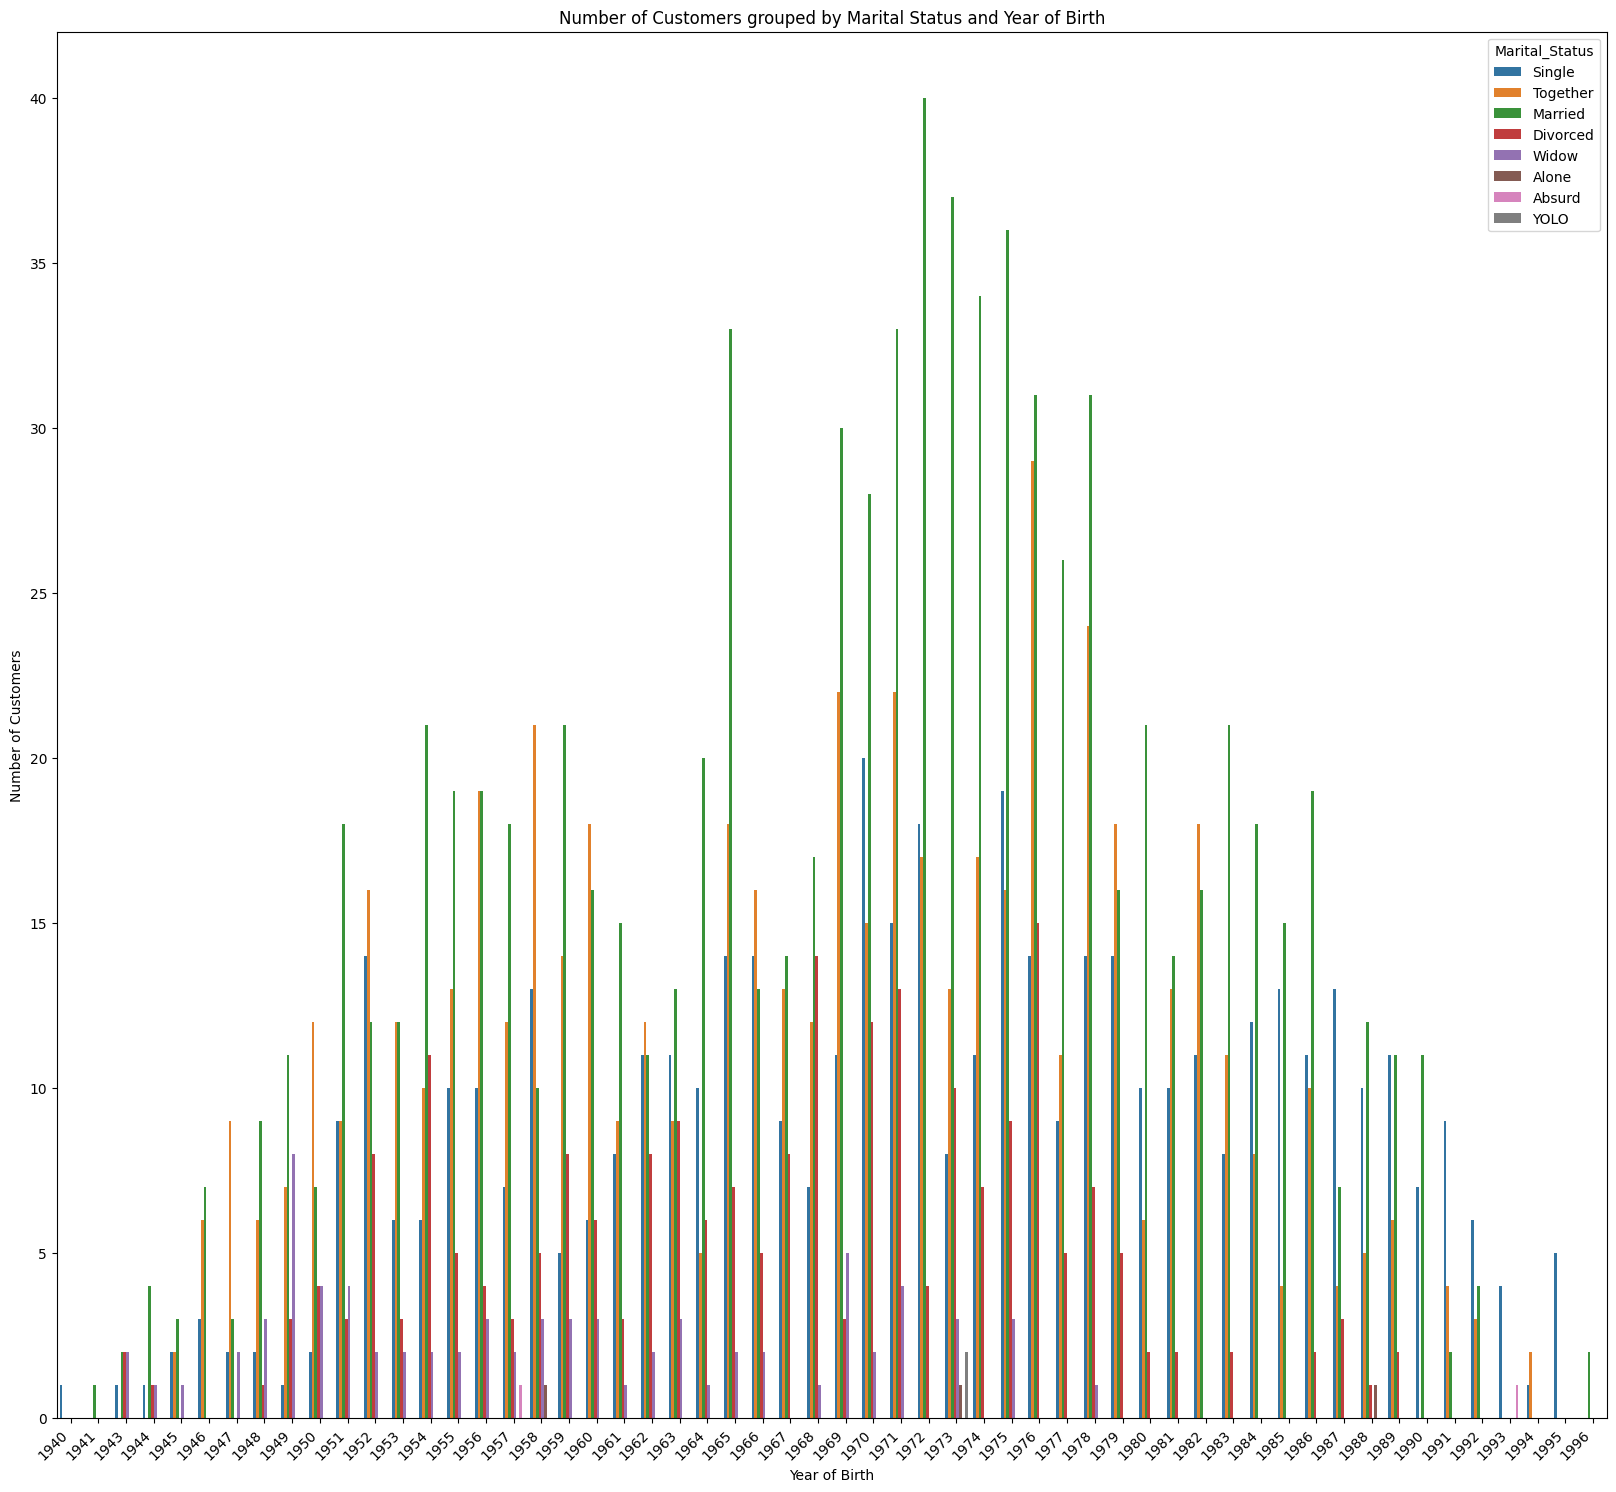

In [18]:
fig, axes = plt.subplots(figsize=(20, 18))
ax = sns.countplot(df, x='Year_Birth', hue='Marital_Status')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Number of Customers grouped by Marital Status and Year of Birth')
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Number of Customers')

/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/1416069537.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(df, x='Year_Birth', hue='Marital_Status')
/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/1416069537.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0, 0.5, 'Density')

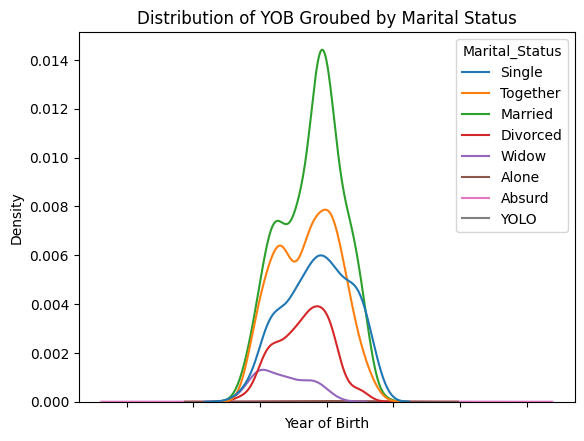

In [19]:
# fig, axes = plt.subplots(figsize=(20, 18))
ax = sns.kdeplot(df, x='Year_Birth', hue='Marital_Status')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Distribution of YOB Groubed by Marital Status')
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Density')

Text(0, 0.5, 'Number of Customers')

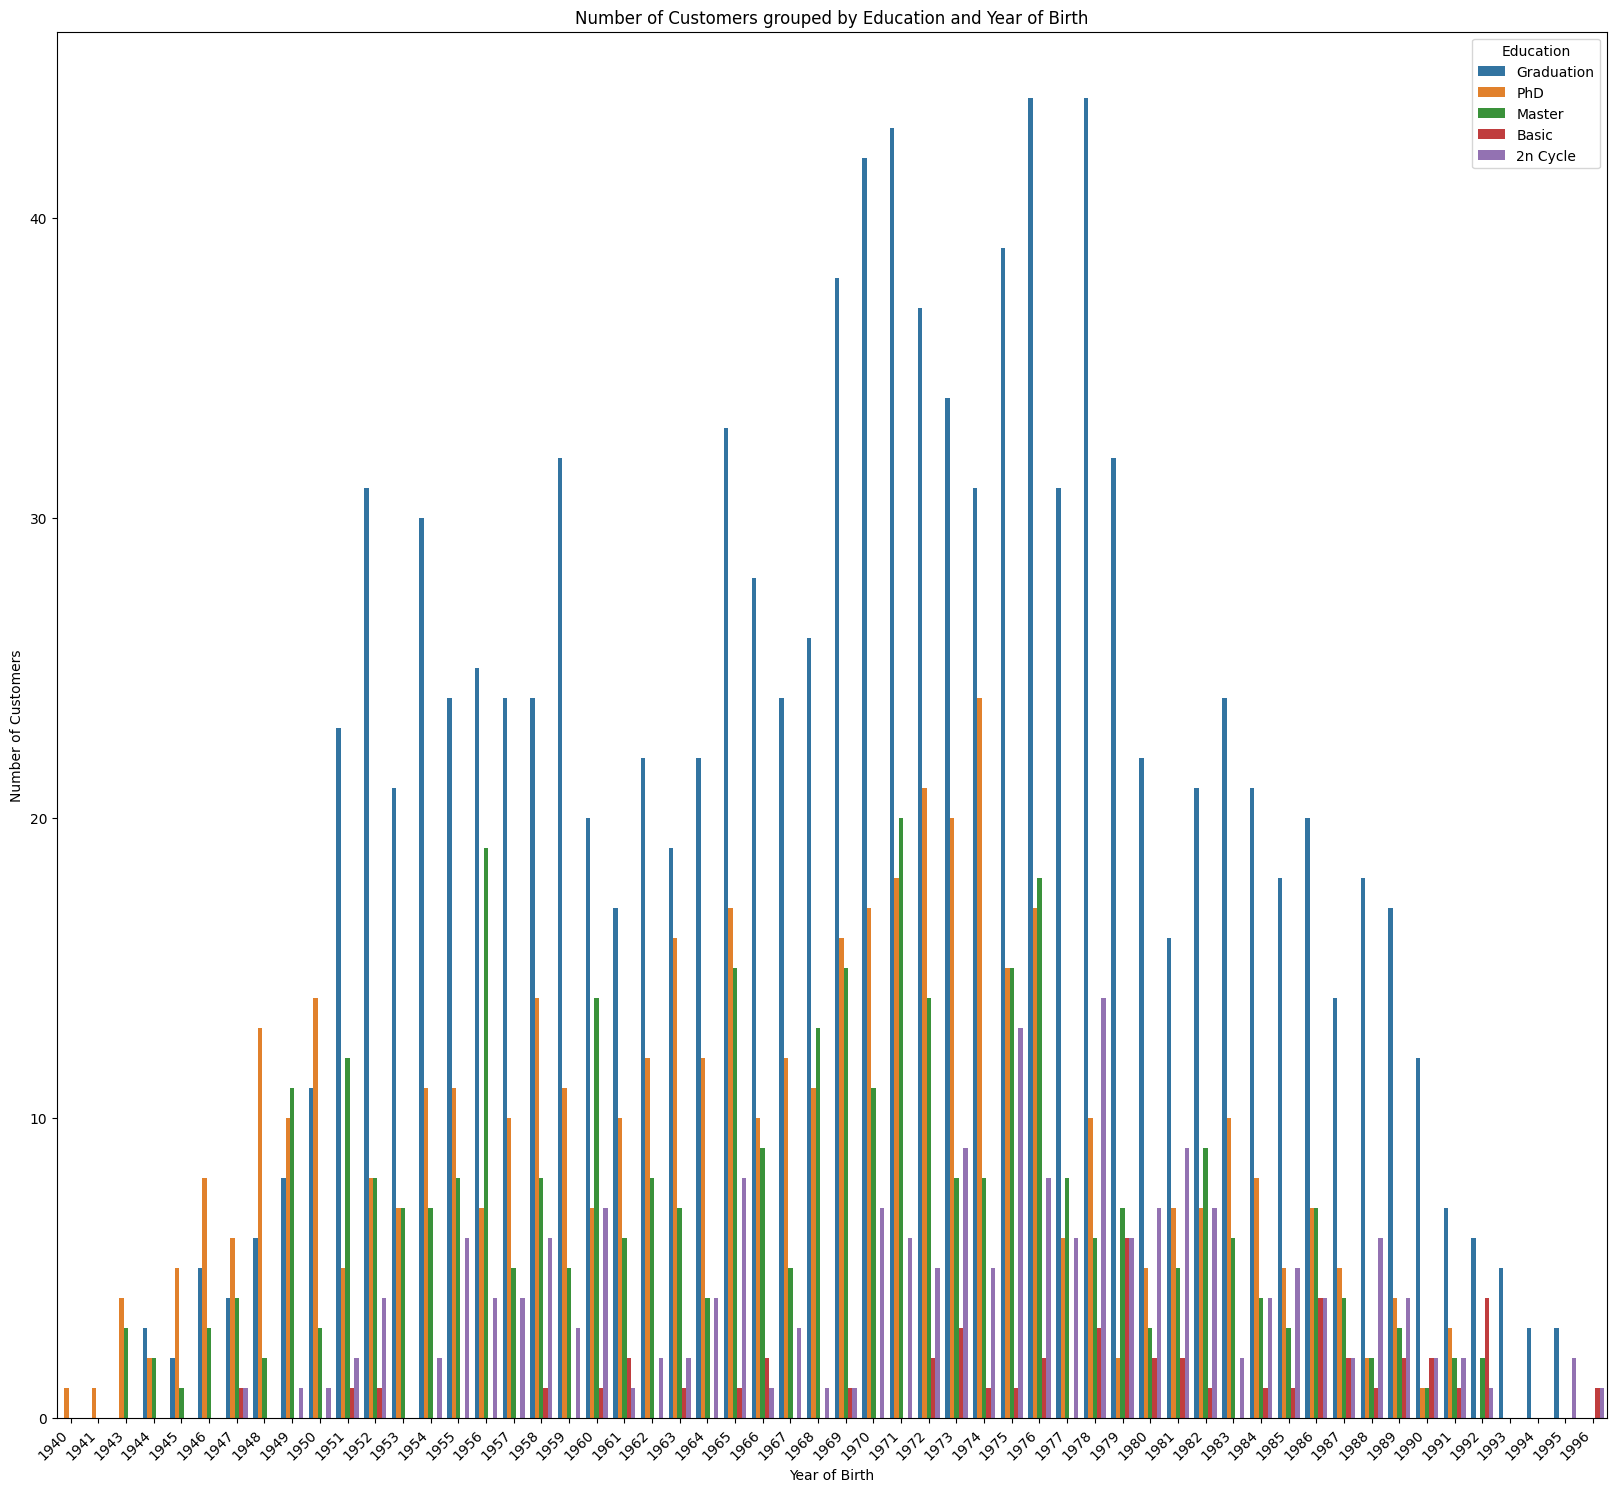

In [20]:
fig, axes = plt.subplots(figsize=(20, 18))
ax = sns.countplot(df, x='Year_Birth', hue='Education')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Number of Customers grouped by Education and Year of Birth')
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Number of Customers')

/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/215375524.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0, 0.5, 'Density')

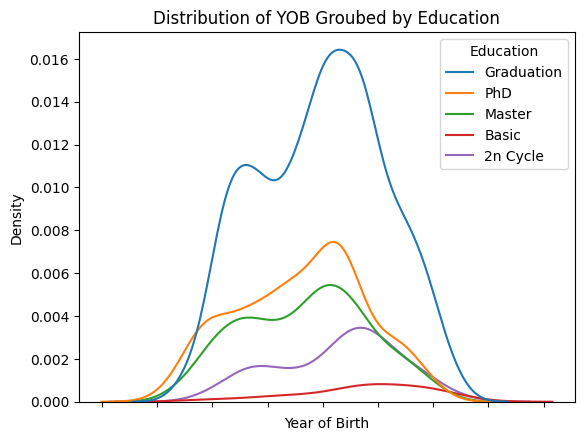

In [21]:
# fig, axes = plt.subplots(figsize=(20, 18))
ax = sns.kdeplot(df, x='Year_Birth', hue='Education')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title('Distribution of YOB Groubed by Education')
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Density')

/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/155599993.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0, 0.5, 'Income')

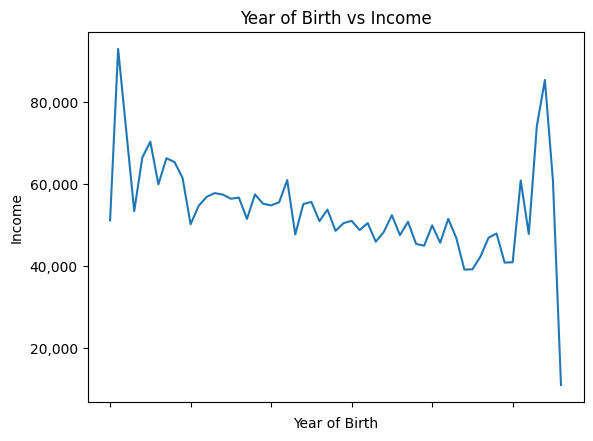

In [22]:
# fig, axes = plt.subplots(figsize=(20, 18))
df_by = df.groupby(by='Year_Birth', as_index=False).mean(numeric_only=True)
ax = sns.lineplot(df_by, x='Year_Birth', y='Income')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax.set_title('Year of Birth vs Income')
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Income')

/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/3838380784.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0, 0.5, 'Income')

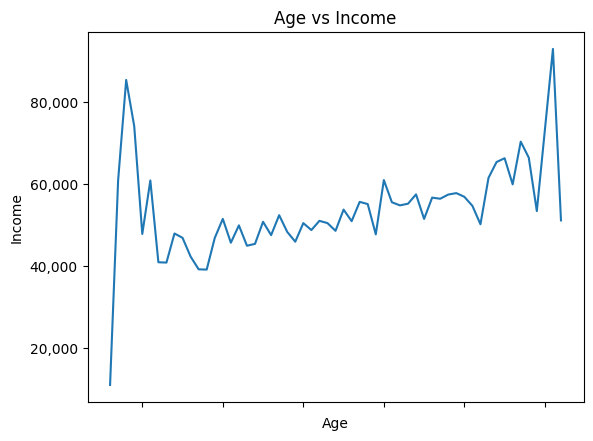

In [23]:
# fig, axes = plt.subplots(figsize=(20, 18))
df_age = df.groupby(by='Age', as_index=False).mean(numeric_only=True)
ax = sns.lineplot(df_age, x='Age', y='Income')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax.set_title('Age vs Income')
ax.set_xlabel('Age')
ax.set_ylabel('Income')

Text(0, 0.5, 'Recency')

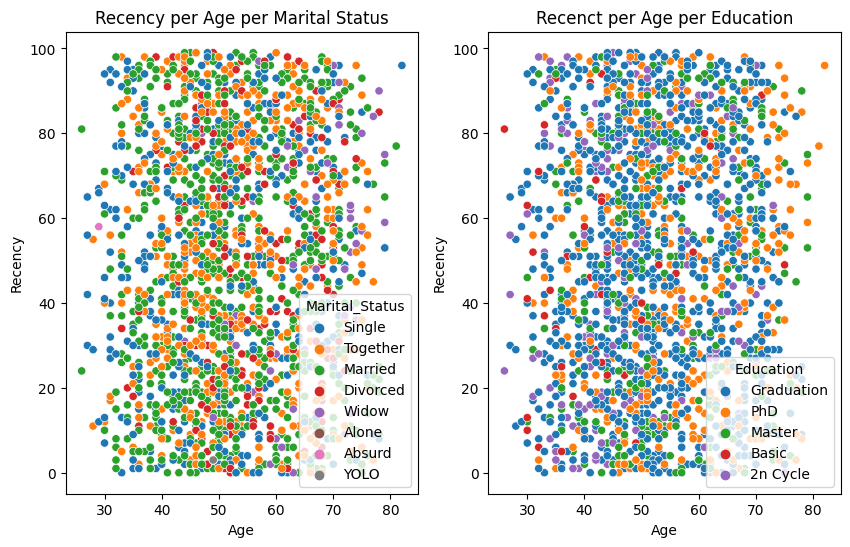

In [24]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))
ax = sns.scatterplot(df, x='Age', y='Recency', hue='Marital_Status', ax=ax0)
ax.set_title('Recency per Age per Marital Status')
ax.set_xlabel('Age')
ax.set_ylabel('Recency')

ax = sns.scatterplot(df, x='Age', y='Recency', hue='Education', ax=ax1)
ax.set_title('Recenct per Age per Education')
ax.set_xlabel('Age')
ax.set_ylabel('Recency')

/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/1114586391.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/1114586391.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0, 0.5, 'Recency')

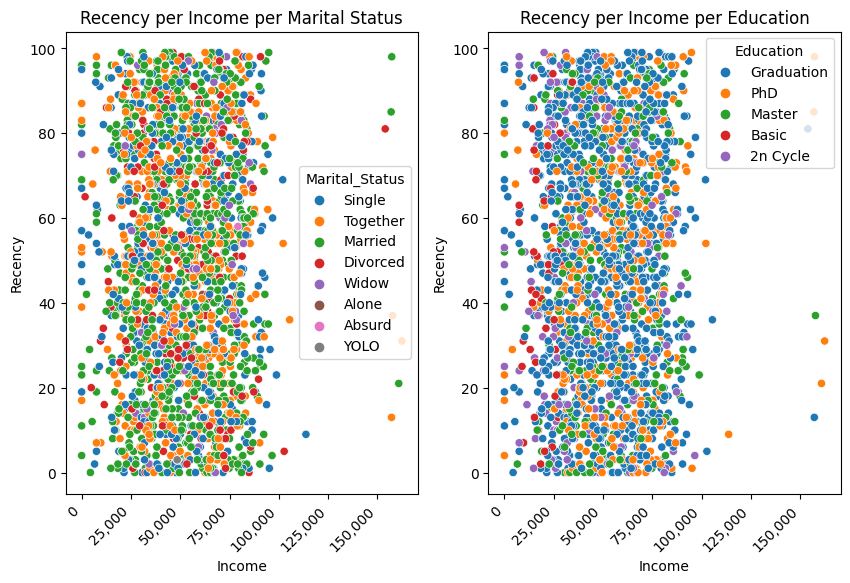

In [25]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))
ax = sns.scatterplot(df, x='Income', y='Recency', hue='Marital_Status', ax=ax0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax.set_title('Recency per Income per Marital Status')
ax.set_xlabel('Income')
ax.set_ylabel('Recency')

ax = sns.scatterplot(df, x='Income', y='Recency', hue='Education', ax=ax1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax.set_title('Recency per Income per Education')
ax.set_xlabel('Income')
ax.set_ylabel('Recency')

Text(0, 0.5, 'Income')

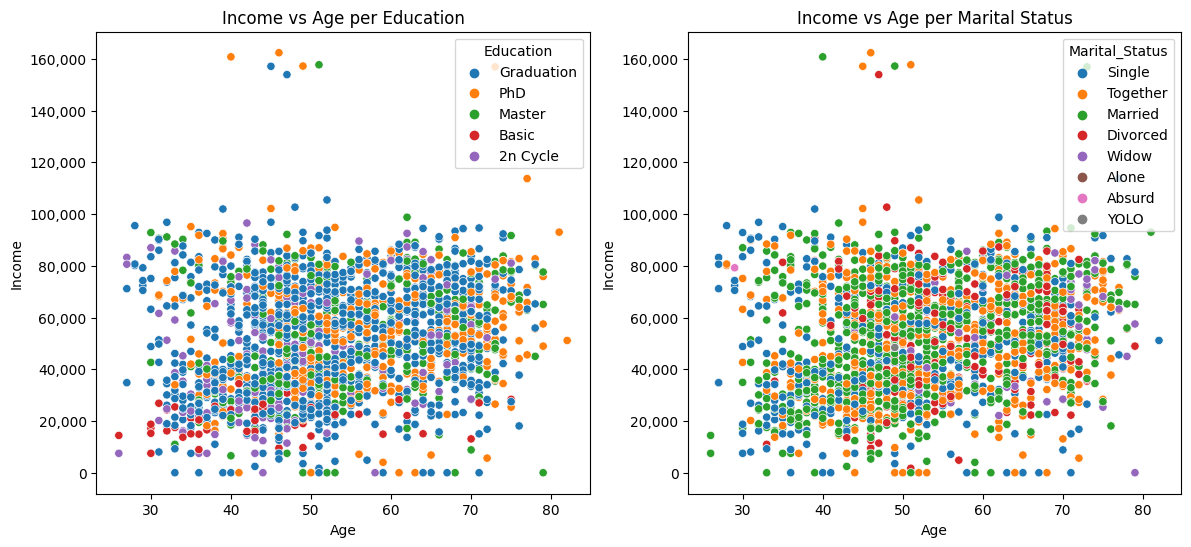

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax = sns.scatterplot(df, x='Age', y='Income', hue='Education', ax=ax0)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax.set_title('Income vs Age per Education')
ax.set_xlabel('Age')
ax.set_ylabel('Income')

ax = sns.scatterplot(df, x='Age', y='Income', hue='Marital_Status', ax=ax1)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax.set_title('Income vs Age per Marital Status')
ax.set_xlabel('Age')
ax.set_ylabel('Income')

/var/folders/7n/_2mtj9_n18936qksyr5qs1zw0000gn/T/ipykernel_1487/3875147236.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(df, x='Recency', hue='Marital_Status', ax=ax0)


Text(0, 0.5, 'Density')

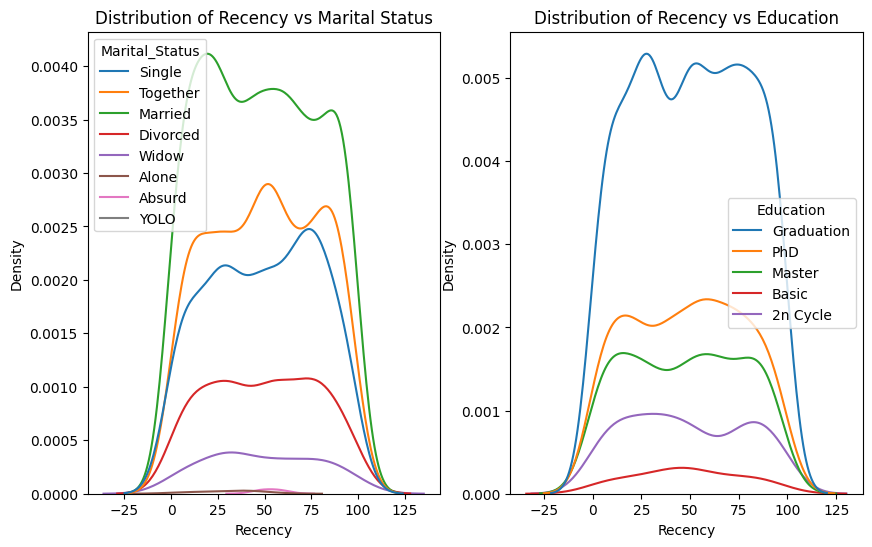

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))
ax = sns.kdeplot(df, x='Recency', hue='Marital_Status', ax=ax0)
ax.set_title('Distribution of Recency vs Marital Status')
ax.set_xlabel('Recency')
ax.set_ylabel('Density')

ax = sns.kdeplot(df, x='Recency', hue='Education', ax=ax1)
ax.set_title('Distribution of Recency vs Education')
ax.set_xlabel('Recency')
ax.set_ylabel('Density')

Text(0, 0.5, 'Total Spend')

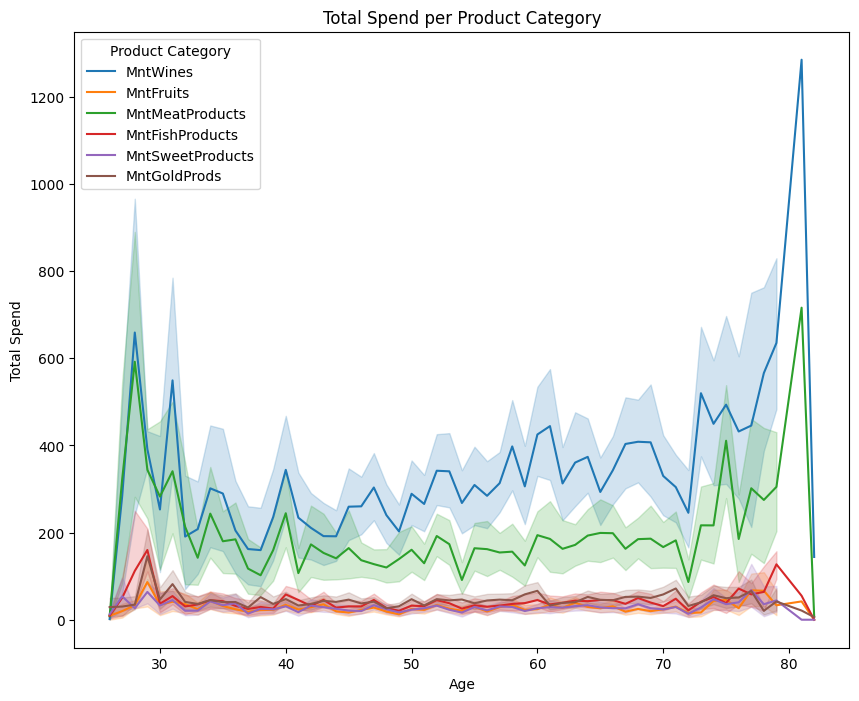

In [29]:
data = pd.melt(df, 'Age', value_vars=['MntWines', 'MntFruits', 'MntMeatProducts',
               'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], var_name='Product Category')

fig, axes = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(data, x='Age', y='value', hue='Product Category')
ax.set_title('Total Spend per Product Category')
ax.set_xlabel('Age')
ax.set_ylabel('Total Spend')

Text(0, 0.5, 'Number of Deals')

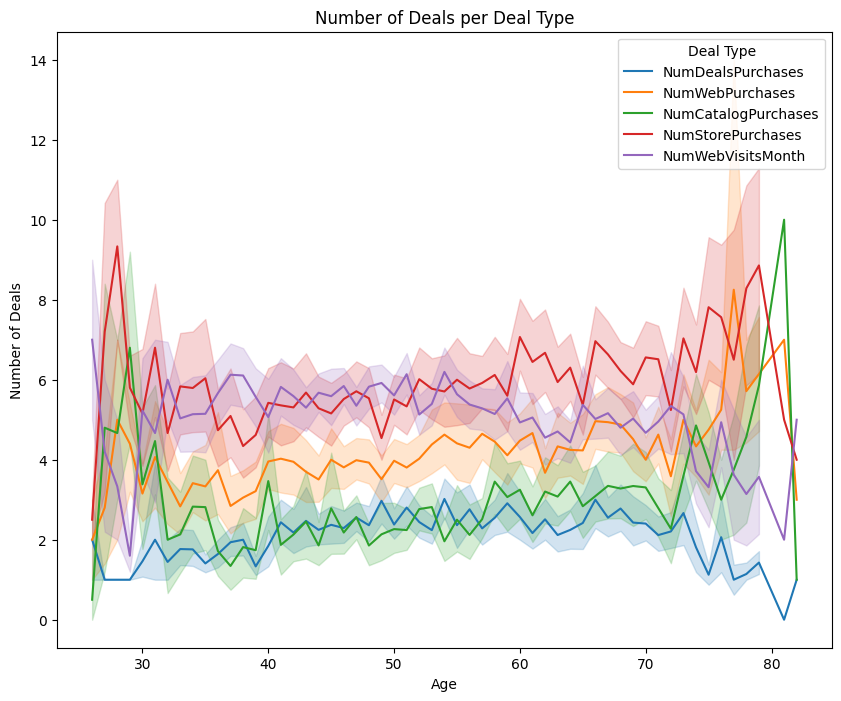

In [30]:
data = pd.melt(df, 'Age', value_vars=['NumDealsPurchases', 'NumWebPurchases',
               'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'], var_name='Deal Type')

fig, axes = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(data, x='Age', y='value', hue='Deal Type')
ax.set_title('Number of Deals per Deal Type')
ax.set_xlabel('Age')
ax.set_ylabel('Number of Deals')

Text(0, 0.5, 'Acceptance Ratio')

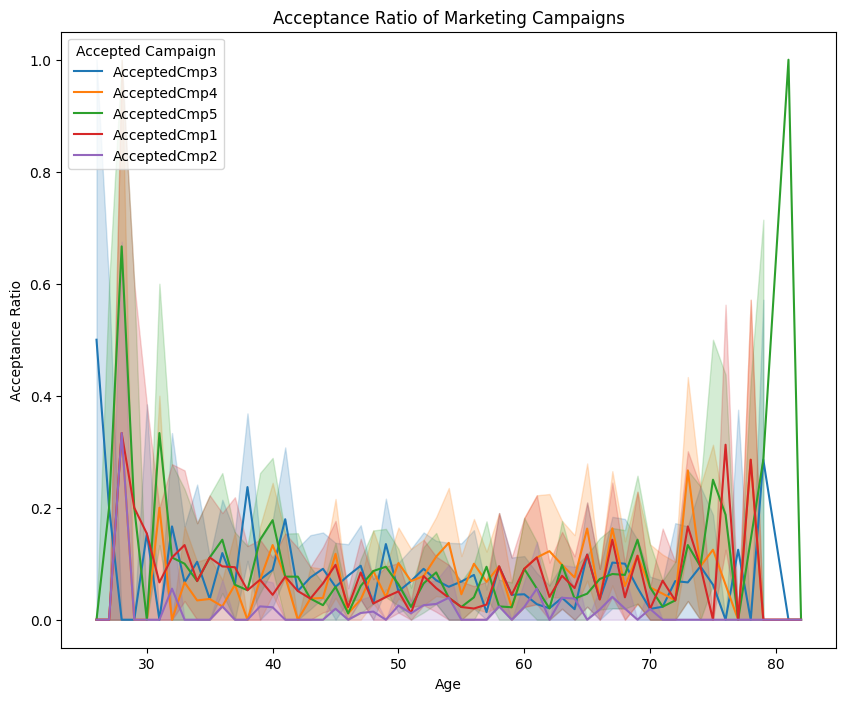

In [31]:
data = pd.melt(df, 'Age', value_vars=['AcceptedCmp3', 'AcceptedCmp4',
               'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2'], var_name='Accepted Campaign')

fig, axes = plt.subplots(figsize=(10, 8))
ax = sns.lineplot(data, x='Age', y='value', hue='Accepted Campaign')
ax.set_title('Acceptance Ratio of Marketing Campaigns')
ax.set_xlabel('Age')
ax.set_ylabel('Acceptance Ratio')

Text(0, 0.5, 'Number of Customers')

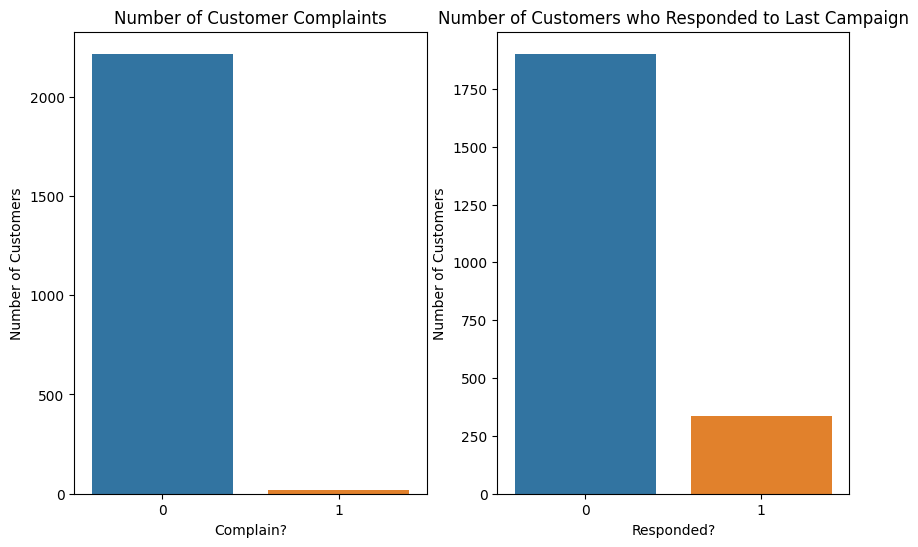

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))
ax = sns.countplot(df, x='Complain', ax=ax0)
ax.set_title('Number of Customer Complaints')
ax.set_xlabel('Complain?')
ax.set_ylabel('Number of Customers')

ax = sns.countplot(df, x='Response', ax=ax1)
ax.set_title('Number of Customers who Responded to Last Campaign')
ax.set_xlabel('Responded?')
ax.set_ylabel('Number of Customers')

Text(0.5, 1.0, 'Number of Customer Responses to Last Ad Campaign by Age')

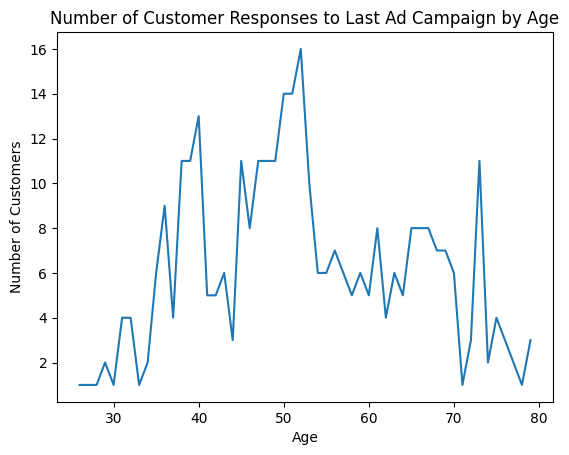

In [33]:
df_response = df[(df['Response'] == 1)].groupby(
    by='Age', as_index=False)['ID'].count()

ax = sns.lineplot(df_response, x='Age', y='ID')
ax.set_xlabel('Age')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Customer Responses to Last Ad Campaign by Age')

# Clustering (using the original dataset)

In [34]:
# create a dataframe copy just for feature selection
df_clustering = df.copy(deep=True)

# encode the categorical data
cat_cols = [
    col for col in df_clustering.columns if df_clustering[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_clustering[cat_cols] = oe.fit_transform(df_clustering[cat_cols])

# columns chosen to ignore
cols_to_drop = ['ID', 'Year_Birth', 'Dt_Customer']

['Education', 'Marital_Status']


In [35]:
# convert tenure from timedelta to int
df_clustering['Tenure'] = df_clustering['Tenure'].dt.days

In [36]:
# brief view of data
df_clustering.head(3)

ID  Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957        2.0             4.0  58138.0        0         0   
1  2174        1954        2.0             4.0  46344.0        1         1   
2  4141        1965        2.0             5.0  71613.0        0         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  Age  Tenure  
0              3         11         1   65    3713  
1              3         11         0   68    3163  
2              3         11         0   57    3362  

[3 rows x 31 columns]

In [37]:
# define x and drop some columns
x = df_clustering.drop(cols_to_drop, axis=1).values

In [38]:
# view x briefly
x[:1]

array([[2.0000e+00, 4.0000e+00, 5.8138e+04, 0.0000e+00, 0.0000e+00,
        5.8000e+01, 6.3500e+02, 8.8000e+01, 5.4600e+02, 1.7200e+02,
        8.8000e+01, 8.8000e+01, 3.0000e+00, 8.0000e+00, 1.0000e+01,
        4.0000e+00, 7.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 1.1000e+01,
        1.0000e+00, 6.5000e+01, 3.7130e+03]])

## K-Means

In [39]:
wcss = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

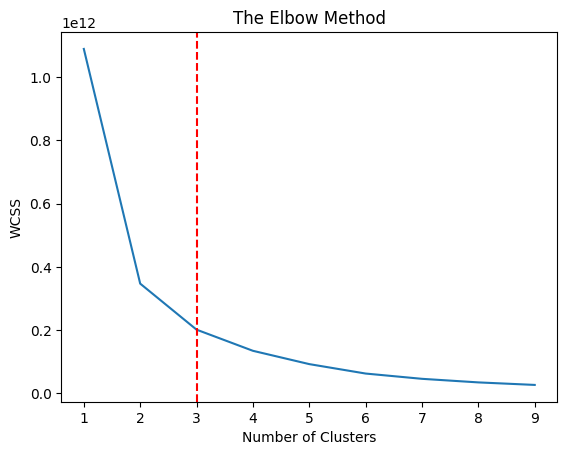

In [41]:
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.axvline(x=3, c='r', linestyle='--')

# 4 clusters is the best value

In [42]:
# create the model using the k-means++ initializor and 3 clusters
kmean_model = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmean_model.fit(x)

# predict
y_pred_kmeans = kmean_model.predict(x)
y_pred_kmeans

array([0, 0, 1, ..., 0, 1, 0], dtype=int32)

In [43]:
# add clusters to dataframe
df_clustering['Cluster_Kmeans'] = y_pred_kmeans

In [44]:
kmean_model.cluster_centers_

array([[2.52919255e+00, 3.73664596e+00, 5.17789342e+04, 4.17391304e-01,
        8.09937888e-01, 4.96285714e+01, 2.80356522e+02, 1.81627329e+01,
        9.57018634e+01, 2.42745342e+01, 1.73850932e+01, 4.47031056e+01,
        3.08695652e+00, 4.67950311e+00, 2.20124224e+00, 5.98509317e+00,
        5.75279503e+00, 6.70807453e-02, 8.44720497e-02, 4.96894410e-03,
        1.86335404e-02, 1.49068323e-02, 6.21118012e-03, 3.00000000e+00,
        1.10000000e+01, 1.10559006e-01, 5.57267081e+01, 3.41431429e+03],
       [2.48275862e+00, 3.73706897e+00, 7.67788506e+04, 9.05172414e-02,
        3.56321839e-01, 4.90890805e+01, 6.16331897e+02, 5.67284483e+01,
        3.94923851e+02, 8.23045977e+01, 5.97471264e+01, 7.01465517e+01,
        1.63074713e+00, 5.42241379e+00, 5.41379310e+00, 8.40373563e+00,
        3.19540230e+00, 7.04022989e-02, 1.33620690e-01, 2.25574713e-01,
        1.81034483e-01, 2.58620690e-02, 7.18390805e-03, 3.00000000e+00,
        1.10000000e+01, 2.35632184e-01, 5.44367816e+01, 3.39226

Text(0.5, 1.0, 'Customer Clusters')

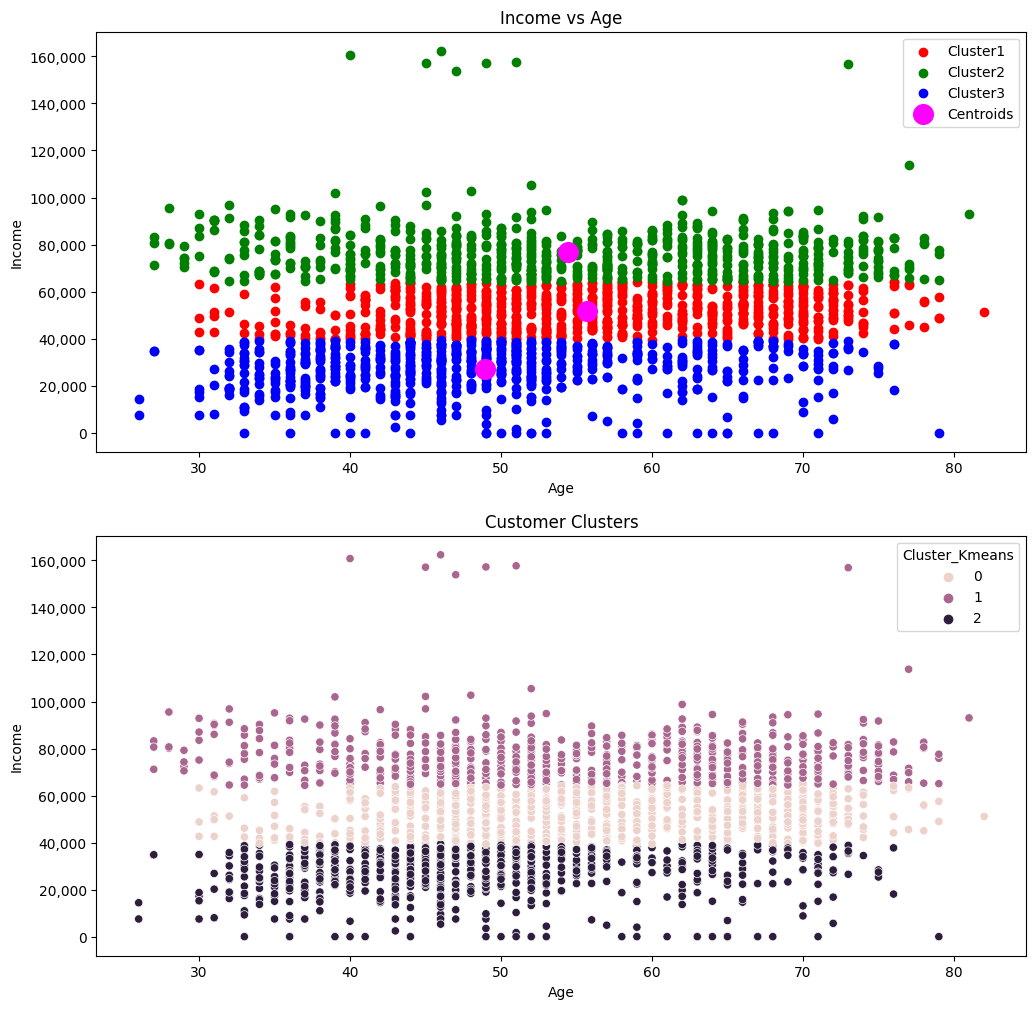

In [45]:
# plot the clusters on a scatter plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))

# plt
ax0.scatter(x[y_pred_kmeans == 0, 26],
            x[y_pred_kmeans == 0, 2], c='r', label='Cluster1')
ax0.scatter(x[y_pred_kmeans == 1, 26],
            x[y_pred_kmeans == 1, 2], c='g', label='Cluster2')
ax0.scatter(x[y_pred_kmeans == 2, 26],
            x[y_pred_kmeans == 2, 2], c='b', label='Cluster3')

ax0.scatter(kmean_model.cluster_centers_[:, 26], kmean_model.cluster_centers_[
            :, 2], s=200, c='magenta', label='Centroids')

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))

ax0.set_title('Income vs Age')
ax0.set_xlabel('Age')
ax0.set_ylabel('Income')
ax0.legend()

# seaborn
ax1 = sns.scatterplot(df_clustering, x='Age', y='Income', hue='Cluster_Kmeans')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Income')
ax1.set_title('Customer Clusters')

## Hierarchical

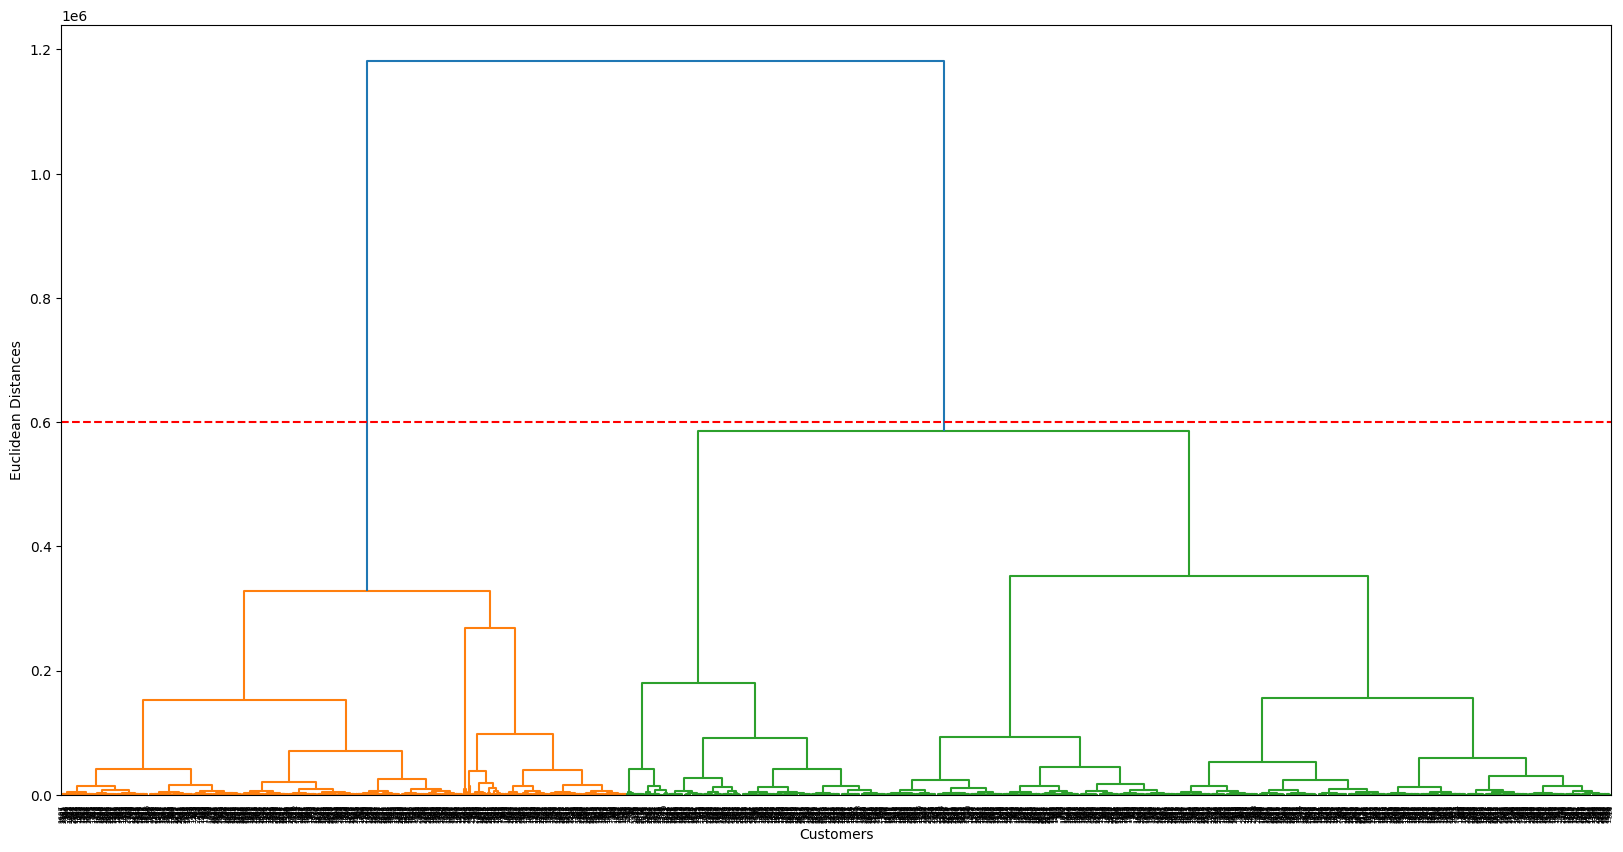

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
dendro_chart = dendrogram(linkage(x, method='ward')
                          )  # could be single or other
ax.set_xlabel('Customers')
ax.set_ylabel('Euclidean Distances')

ax.axhline(y=600000, c='r', linestyle='--')

# looks like 3 clusters this time around

In [47]:
# create the model
agg_cluster = AgglomerativeClustering(
    n_clusters=3, affinity='euclidean', linkage='ward')

# predict
y_pred_agg = agg_cluster.fit_predict(x)

In [48]:
# add clusters to dataframe
df_clustering['Cluster_Agg'] = y_pred_agg

Text(0.5, 1.0, 'Customer Clusters')

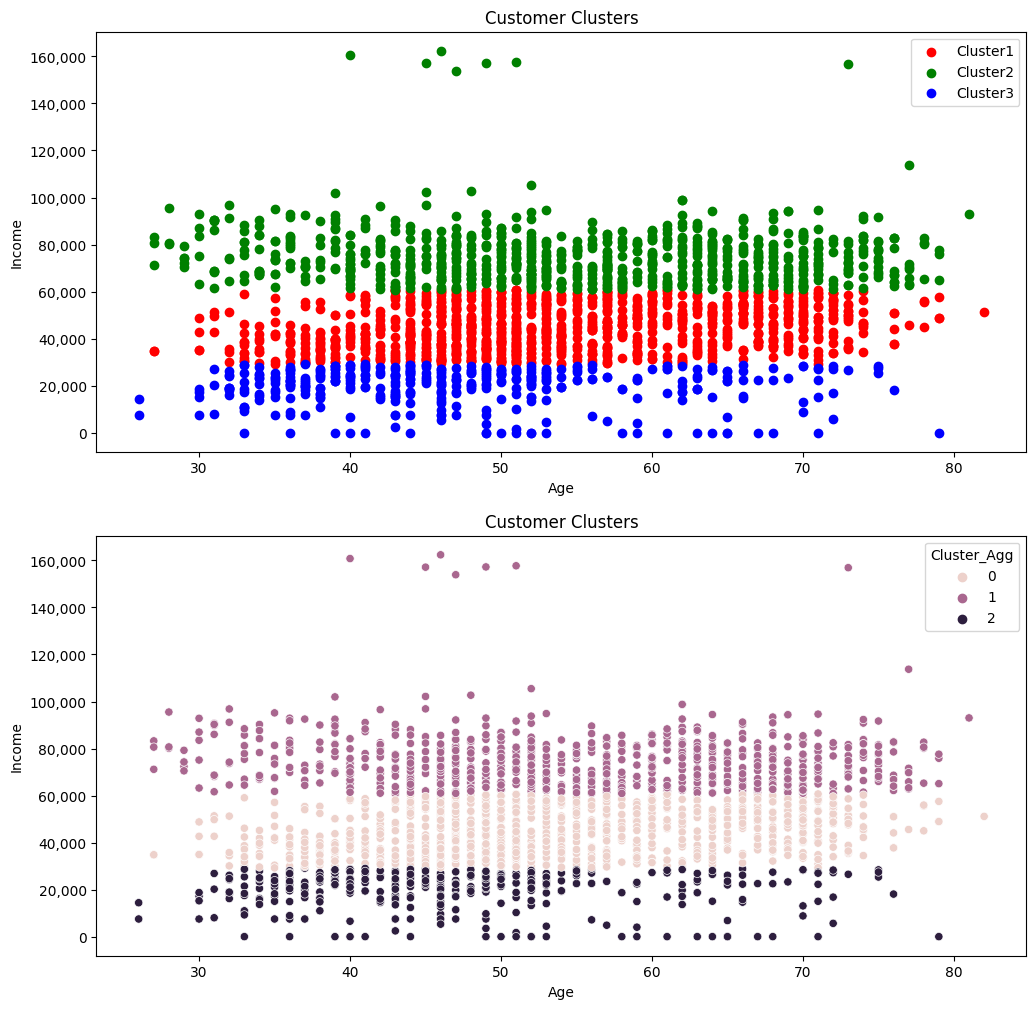

In [49]:
# plot the clusters on a scatter plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))

# plt
ax0.scatter(x[y_pred_agg == 0, 26],
            x[y_pred_agg == 0, 2], c='r', label='Cluster1')
ax0.scatter(x[y_pred_agg == 1, 26],
            x[y_pred_agg == 1, 2], c='g', label='Cluster2')
ax0.scatter(x[y_pred_agg == 2, 26],
            x[y_pred_agg == 2, 2], c='b', label='Cluster3')

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))

ax0.set_title('Customer Clusters')
ax0.set_xlabel('Age')
ax0.set_ylabel('Income')
ax0.legend()

# plot the clusters on a scatter plot using seaborn
ax1 = sns.scatterplot(df_clustering, x='Age', y='Income', hue='Cluster_Agg')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Income')
ax1.set_title('Customer Clusters')

## DBScan

56


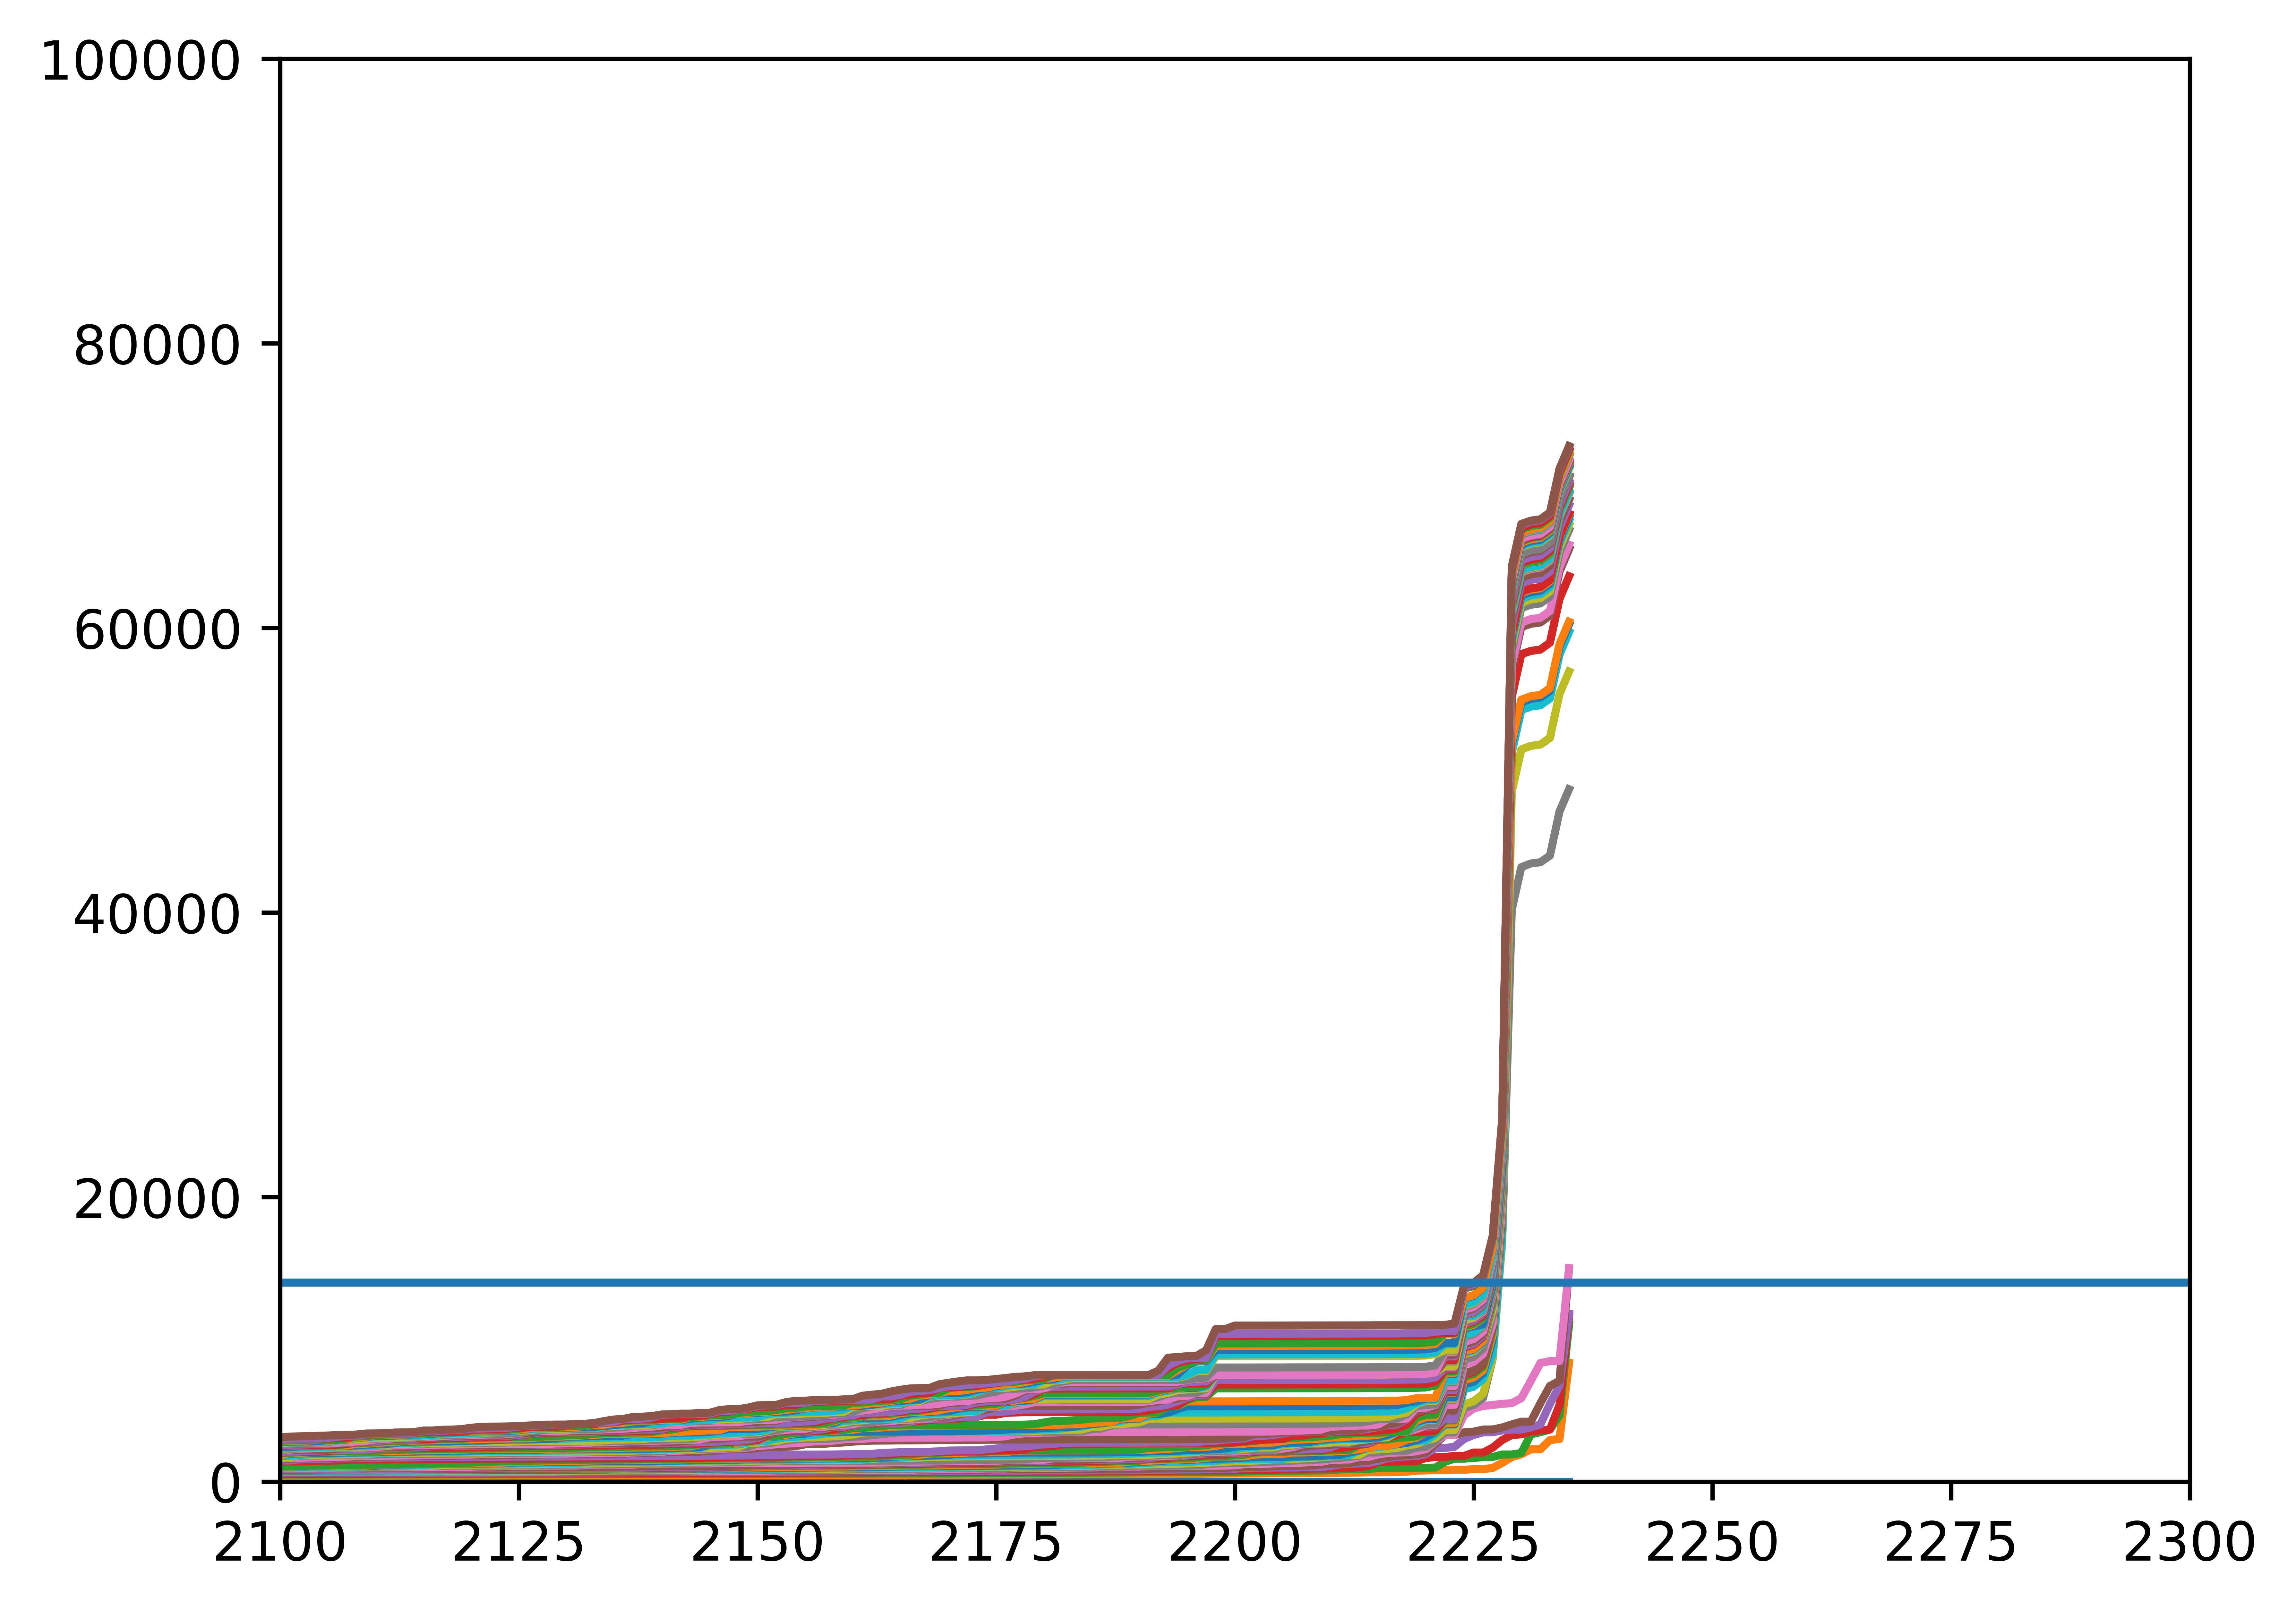

In [57]:
# for datasets of dimensions 2 or above use min_points
# equal to twice the dimension size
min_points = 2 * x.shape[1]
print(min_points)

# build a KNN model and train it
neighbor_model = NearestNeighbors(n_neighbors=min_points)
neighbors = neighbor_model.fit(x)

# distance between the core points and their neighbors
# and their indices
distances, indices = neighbors.kneighbors(x)

distances = np.sort(distances, axis=0)
# print(distances)
plt.figure(dpi=1200)

# set x and y limits
plt.xlim([2100, 2300])
plt.ylim([0, 100000])

# for i in range(len(distances[0])):
#     d = distances[:, i]
#     # print(d)
#     plt.plot(d)

plt.plot(distances)

plt.axhline(y=14000)

Text(0, 0.5, 'Silhouette Score')

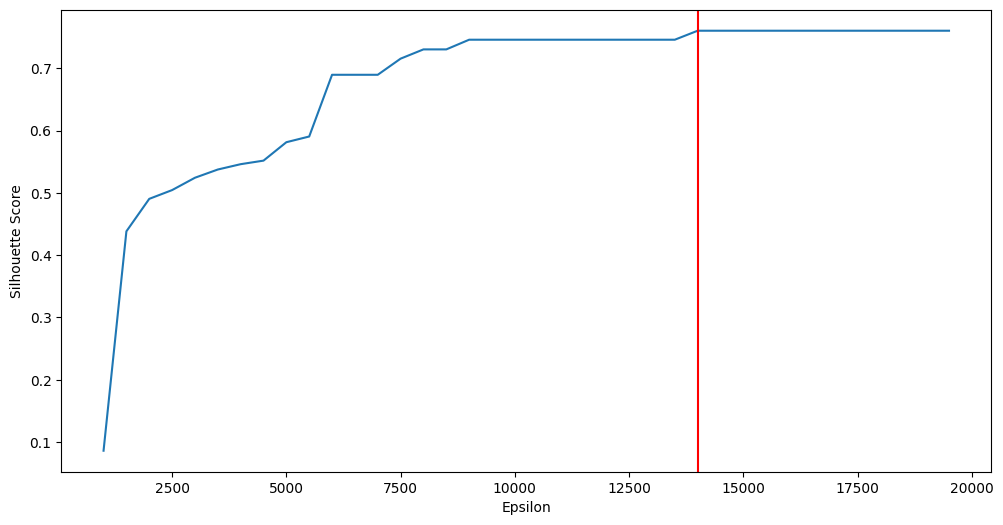

In [55]:
# let's get the eps value through silhoutte score validation
result = {}

for eps in np.arange(1000, 20000, 500):
    db_model = DBSCAN(eps=eps, min_samples=min_points)
    db_model.fit(x)
    y_pred_db = db_model.fit_predict(x)
    db_sil_score = silhouette_score(x, y_pred_db)
    result.update({eps: db_sil_score})

plt.figure(figsize=(12, 6))
plt.plot(result.keys(), result.values())
plt.axvline(x=14000, c='r')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')

In [58]:
min_point = min_points
eps = 14000

# build the model and train it
dbscan_model = DBSCAN(eps=eps, min_samples=min_point)
dbscan_model.fit(x)

y_pred_dbscan = dbscan_model.fit_predict(x)

In [59]:
# add clusters to dataframe
df_clustering['Cluster_DBScan'] = y_pred_dbscan

In [60]:
np.unique(y_pred_dbscan)

array([-1,  0])

Text(0.5, 1.0, 'Customer Clusters')

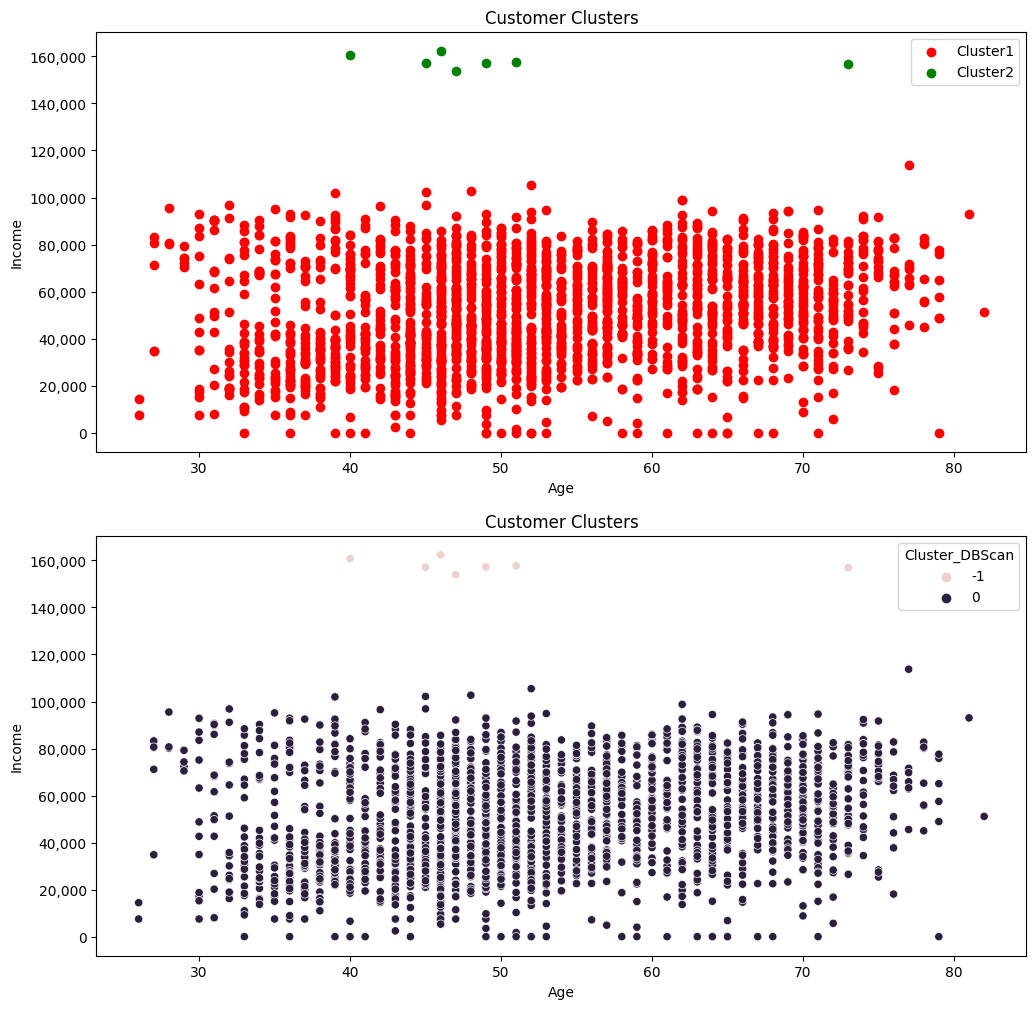

In [61]:
# plot the clusters on a scatter plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))

# plt
ax0.scatter(x[y_pred_dbscan == 0, 26],
            x[y_pred_dbscan == 0, 2], c='r', label='Cluster1')
ax0.scatter(x[y_pred_dbscan == -1, 26],
            x[y_pred_dbscan == -1, 2], c='g', label='Cluster2')

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))

ax0.set_title('Customer Clusters')
ax0.set_xlabel('Age')
ax0.set_ylabel('Income')
ax0.legend()

# plot the clusters on a scatter plot using seaborn
ax1 = sns.scatterplot(df_clustering, x='Age', y='Income', hue='Cluster_DBScan')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax1.set_xlabel('Age')
ax1.set_ylabel('Income')
ax1.set_title('Customer Clusters')

## Cluster Score Comparison

In [62]:
# evaluation by silhouette and davies bouldin scores
# kmeans
sil_score_kmeans = silhouette_score(x, y_pred_kmeans)
db_score_kmeans = davies_bouldin_score(x, y_pred_kmeans)

# evaluation by silhouette and davies bouldin scores
# hierarchical
sil_score_agg = silhouette_score(x, y_pred_agg)
db_score_agg = davies_bouldin_score(x, y_pred_agg)

# evaluation by silhouette and davies bouldin scores
# dbscan
sil_score_dbscan = silhouette_score(x, y_pred_dbscan)
db_score_dbscan = davies_bouldin_score(x, y_pred_dbscan)


headers = ['Silhouette Score', 'Davies Bouldin Score']
tbldata = [
    ['K-Means', sil_score_kmeans, db_score_kmeans],
    ['Hierarchical', sil_score_agg, db_score_agg],
    ['DBScan', sil_score_dbscan, db_score_dbscan]
]

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))

+--------------+--------------------+----------------------+
|              |  Silhouette Score  | Davies Bouldin Score |
+--------------+--------------------+----------------------+
|   K-Means    | 0.534608681656008  |  0.5588246262993208  |
| Hierarchical | 0.5204467629250352 |  0.5502287300733544  |
|    DBScan    | 0.7601351677631919 | 0.18933329235191443  |
+--------------+--------------------+----------------------+


# Principal Component Analysis

In [63]:
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   
3  2014-02-10       26        11          4               20               10   
4  2014-01-19       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  Age    Tenure  
0              3         11         1   65 3713 days  
1              3         11         0   68 3163 days  
2              3         11         0   57 3362 days  
3              3         11         0   38 3189 days  
4              3         11         0   41 3211 days  

[5 rows x 31 columns]

In [64]:
print(x.shape)
print(x[0])

(2236, 28)
[2.0000e+00 4.0000e+00 5.8138e+04 0.0000e+00 0.0000e+00 5.8000e+01
 6.3500e+02 8.8000e+01 5.4600e+02 1.7200e+02 8.8000e+01 8.8000e+01
 3.0000e+00 8.0000e+00 1.0000e+01 4.0000e+00 7.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.0000e+00
 1.1000e+01 1.0000e+00 6.5000e+01 3.7130e+03]


In [65]:
# create the PCA model
pca_model = PCA(n_components=2)

# fit the model with x and apply the dimensionality reduction on X
pc = pca_model.fit_transform(x)

# place the principal components into a new dataframe
df_pc = pd.DataFrame(
    data=pc, columns=['Principal Component 1', 'Principal Component 2'])

pc1 = pca_model.explained_variance_ratio_[0]
pc2 = pca_model.explained_variance_ratio_[1]
print(f'Principal component 1 explains ~{pc1:.6%} while Principal Component 2 explains ~{pc2:.6%}.')

Principal component 1 explains ~99.971429% while Principal Component 2 explains ~0.014421%.


In [66]:
df_pc.head()

Principal Component 1  Principal Component 2
0            6742.589472            -444.699169
1           -5060.895527             344.840912
2           20211.408422             132.509945
3          -24757.261390             120.910666
4            6889.711217             280.240855

[5 rows x 2 columns]

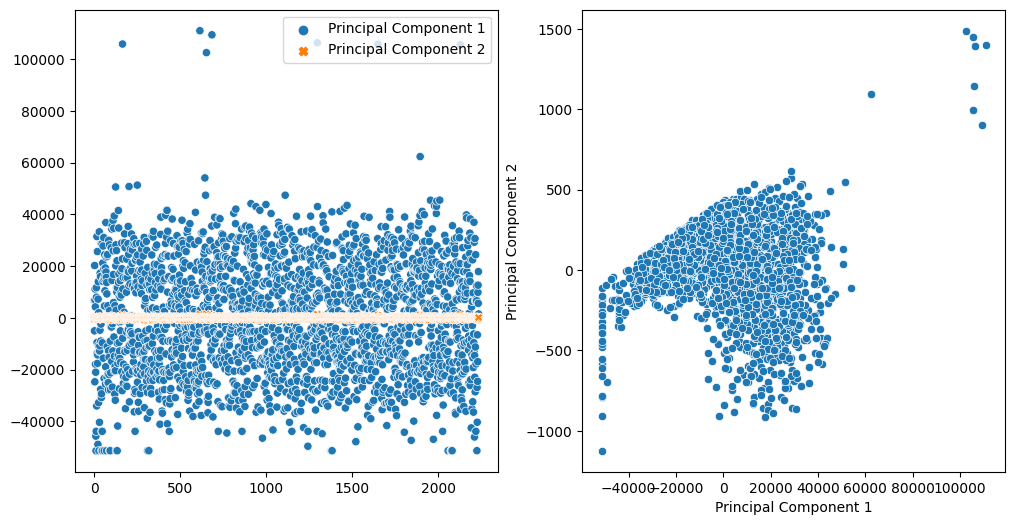

In [67]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax = sns.scatterplot(df_pc, ax=ax0)
ax = sns.scatterplot(df_pc, x='Principal Component 1',
                     y='Principal Component 2', ax=ax1)

## Clustering (using the PCA dataset)

In [83]:
# create a dataframe copy just for feature selection
df_clustering = df_pc.copy(deep=True)

# encode the categorical data
cat_cols = [
    col for col in df_clustering.columns if df_clustering[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_clustering[cat_cols] = oe.fit_transform(df_clustering[cat_cols])

# columns chosen to ignore
cols_to_drop = ['ID', 'Year_Birth', 'Dt_Customer']

[]


In [ ]:
# convert tenure from timedelta to int
# df_clustering['Tenure'] = df_clustering['Tenure'].dt.days

In [84]:
# brief view of data
df_clustering.head(3)

Principal Component 1  Principal Component 2
0            6742.589472            -444.699169
1           -5060.895527             344.840912
2           20211.408422             132.509945

[3 rows x 2 columns]

In [85]:
# define x and drop some columns
# x = df_clustering.drop(cols_to_drop, axis=1).values
x = df_clustering.values

In [86]:
# view x briefly
x[:1]

array([[6742.58947211, -444.699169  ]])

### K-Means

In [87]:
wcss = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=1)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

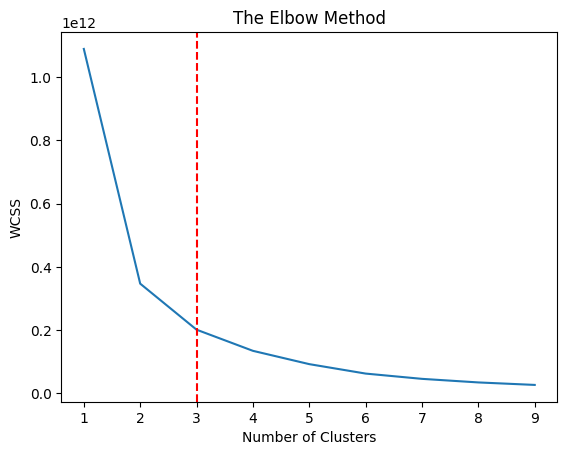

In [88]:
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.axvline(x=3, c='r', linestyle='--')

# 3 clusters is the best value

In [96]:
# create the model using the k-means++ initializor and 4 clusters
kmean_model = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmean_model.fit(x)

# predict
y_pred_kmeans = kmean_model.predict(x)
y_pred_kmeans

array([0, 0, 1, ..., 0, 1, 0], dtype=int32)

In [97]:
# add clusters to dataframe
df_clustering['Cluster_Kmeans'] = y_pred_kmeans

In [98]:
kmean_model.cluster_centers_

array([[ 4.23769923e+02,  3.70513913e+01],
       [ 2.54343998e+04, -5.59331111e+01],
       [-2.44468642e+04,  1.20056079e+01]])

Text(0, 0.5, 'Principal Component 2')

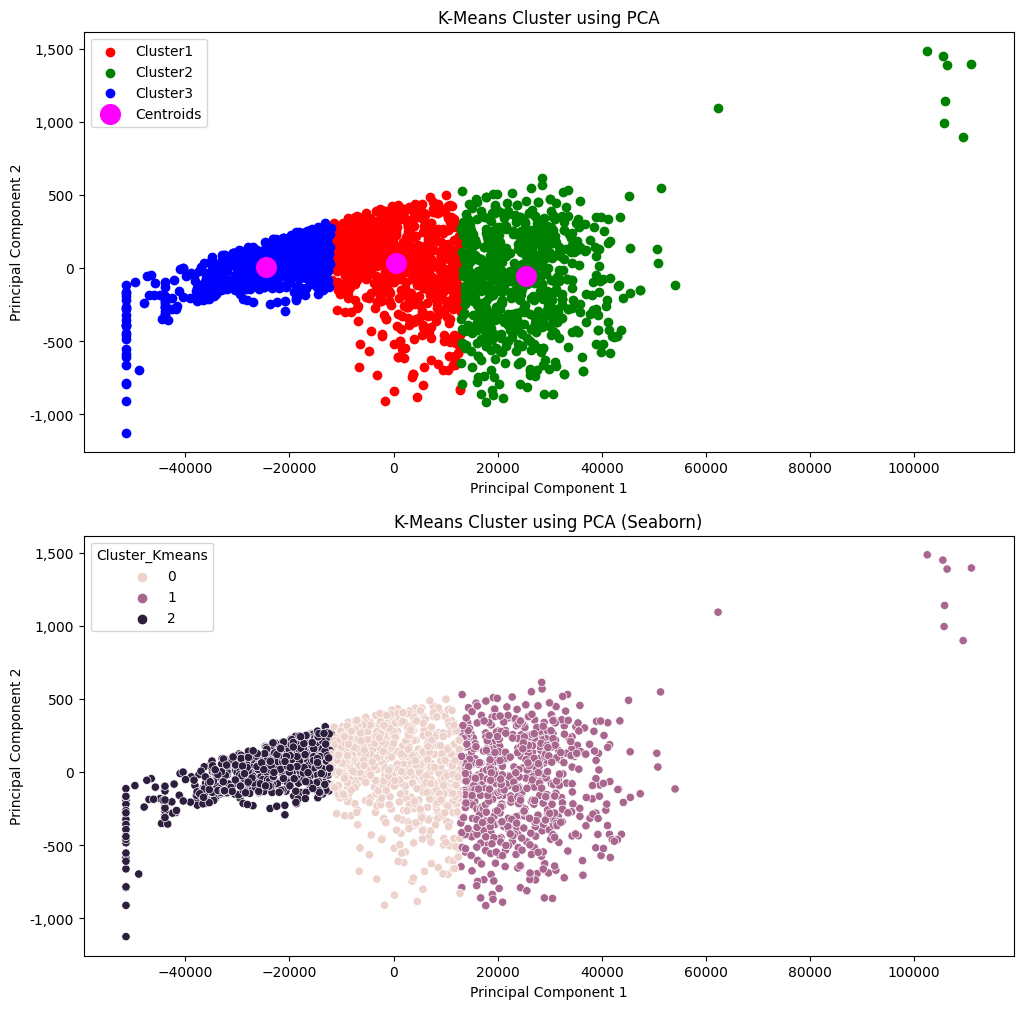

In [101]:
# plot the clusters on a scatter plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))

# plt
ax0.scatter(x[y_pred_kmeans == 0, 0],
            x[y_pred_kmeans == 0, 1], c='r', label='Cluster1')
ax0.scatter(x[y_pred_kmeans == 1, 0],
            x[y_pred_kmeans == 1, 1], c='g', label='Cluster2')
ax0.scatter(x[y_pred_kmeans == 2, 0],
            x[y_pred_kmeans == 2, 1], c='b', label='Cluster3')

ax0.scatter(kmean_model.cluster_centers_[:, 0], kmean_model.cluster_centers_[
            :, 1], s=200, c='magenta', label='Centroids')

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))

ax0.set_title('K-Means Cluster using PCA')
ax0.set_xlabel('Principal Component 1')
ax0.set_ylabel('Principal Component 2')
ax0.legend()

# seaborn
ax1 = sns.scatterplot(df_clustering, x='Principal Component 1',
                      y='Principal Component 2', hue='Cluster_Kmeans')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax1.set_title('K-Means Cluster using PCA (Seaborn)')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')


### Hierarchical

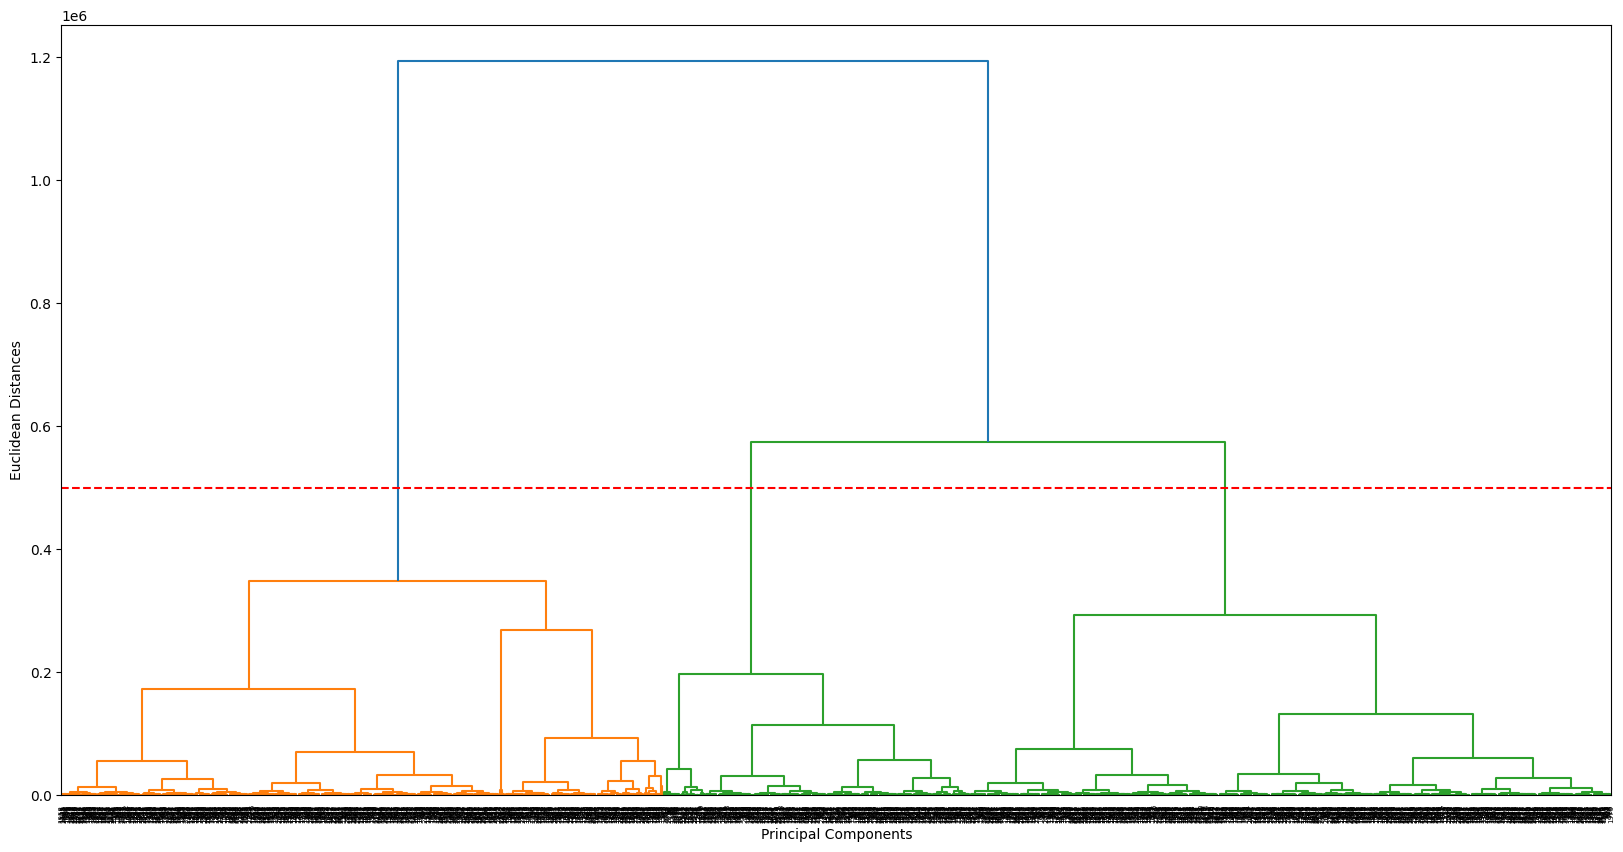

In [103]:
fig, ax = plt.subplots(figsize=(20, 10))
dendro_chart = dendrogram(linkage(x, method='ward')
                          )  # could be single or other
ax.set_xlabel('Principal Components')
ax.set_ylabel('Euclidean Distances')

ax.axhline(y=500000, c='r', linestyle='--')

# looks like 3 clusters this time around

In [104]:
# create the model
agg_cluster = AgglomerativeClustering(
    n_clusters=3, affinity='euclidean', linkage='ward')

# predict
y_pred_agg = agg_cluster.fit_predict(x)

In [105]:
# add clusters to dataframe
df_clustering['Cluster_Agg'] = y_pred_agg

Text(0, 0.5, 'Principal Component 2')

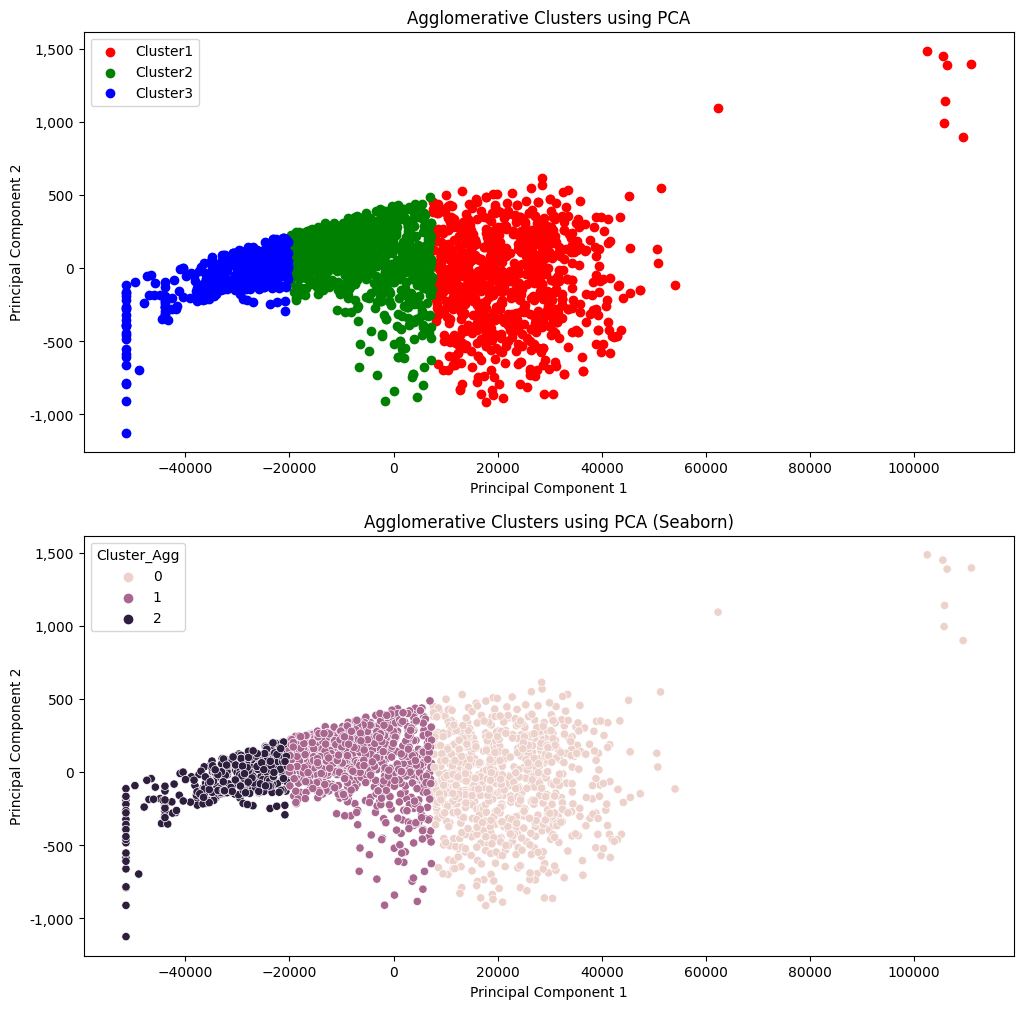

In [108]:
# plot the clusters on a scatter plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))

# plt
ax0.scatter(x[y_pred_agg == 0, 0],
            x[y_pred_agg == 0, 1], c='r', label='Cluster1')
ax0.scatter(x[y_pred_agg == 1, 0],
            x[y_pred_agg == 1, 1], c='g', label='Cluster2')
ax0.scatter(x[y_pred_agg == 2, 0],
            x[y_pred_agg == 2, 1], c='b', label='Cluster3')

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))

ax0.set_title('Agglomerative Clusters using PCA')
ax0.set_xlabel('Principal Component 1')
ax0.set_ylabel('Principal Component 2')
ax0.legend()

# plot the clusters on a scatter plot using seaborn
ax1 = sns.scatterplot(df_clustering, x='Principal Component 1',
                      y='Principal Component 2', hue='Cluster_Agg')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax1.set_title('Agglomerative Clusters using PCA (Seaborn)')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

### DBScan

In [120]:
X = df_pc.values

4


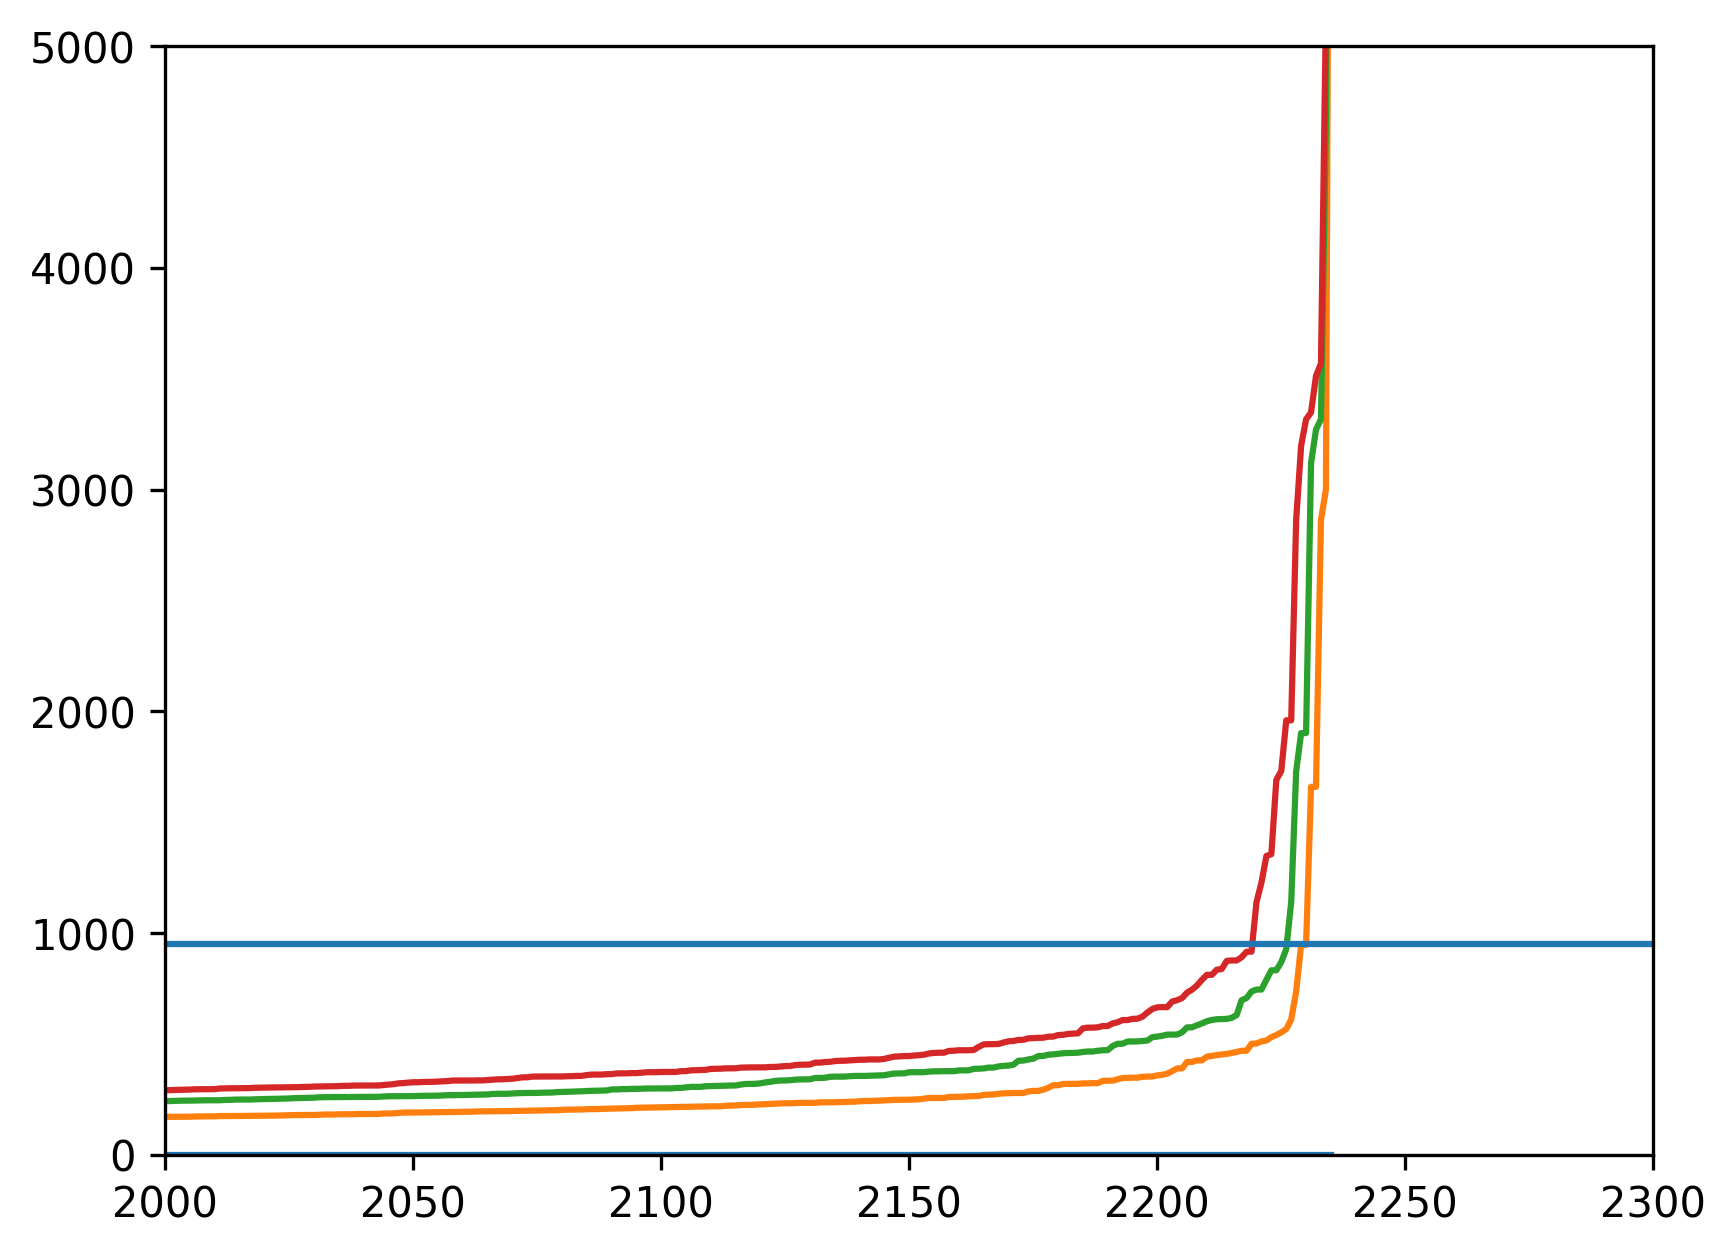

In [126]:
# for datasets of dimensions 2 or above use min_points
# equal to twice the dimension size
min_points = 2 * X.shape[1]
print(min_points)

# build a KNN model and train it
neighbor_model = NearestNeighbors(n_neighbors=min_points)
neighbors = neighbor_model.fit(X)

# distance between the core points and their neighbors
# and their indices
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances, axis=0)
# print(distances)
plt.figure(dpi=300)
# for i in range(len(distances[0])):
#     d = distances[:, i]
#     # print(len(d))
#     plt.plot(d)

# set x and y limits
plt.xlim([2000, 2300])
plt.ylim([0, 5000])
plt.plot(distances)
plt.axhline(y=950)

Text(0, 0.5, 'Silhouette Score')

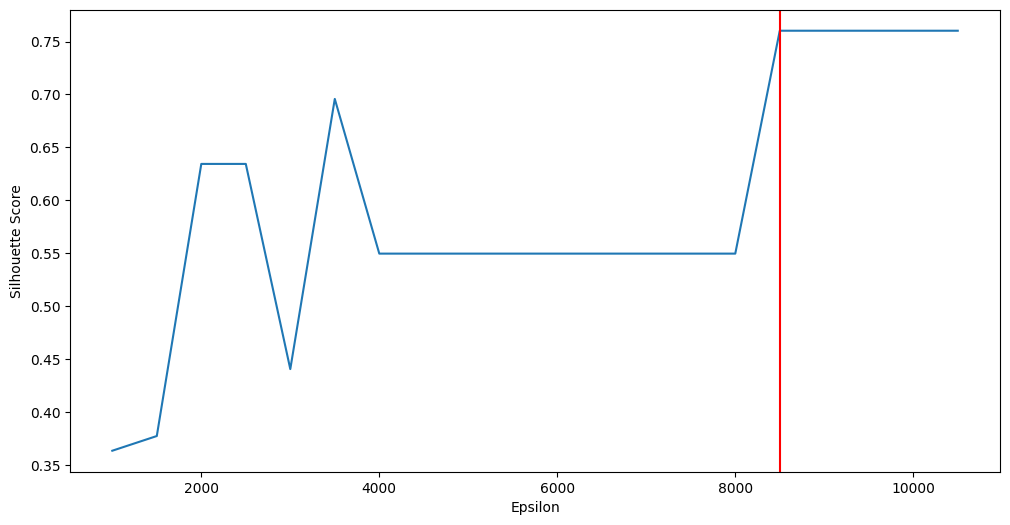

In [124]:
# let's get the eps value through silhoutte score validation
result = {}

for eps in np.arange(1000, 11000, 500):
    db_model = DBSCAN(eps=eps, min_samples=min_points)
    db_model.fit(X)
    y_pred_db = db_model.fit_predict(X)
    db_sil_score = silhouette_score(X, y_pred_db)
    result.update({eps: db_sil_score})

plt.figure(figsize=(12, 6))
plt.plot(result.keys(), result.values())
plt.axvline(x=8500, c='r')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')

In [127]:
min_point = min_points
eps = 4000

# build the model and train it
dbscan_model = DBSCAN(eps=eps, min_samples=min_point)
dbscan_model.fit(X)

y_pred_dbscan = dbscan_model.fit_predict(X)

In [128]:
# add clusters to dataframe
df_clustering['Cluster_DBScan'] = y_pred_dbscan

In [129]:
np.unique(y_pred_dbscan)

array([-1,  0,  1])

Text(0, 0.5, 'Principal Component 2')

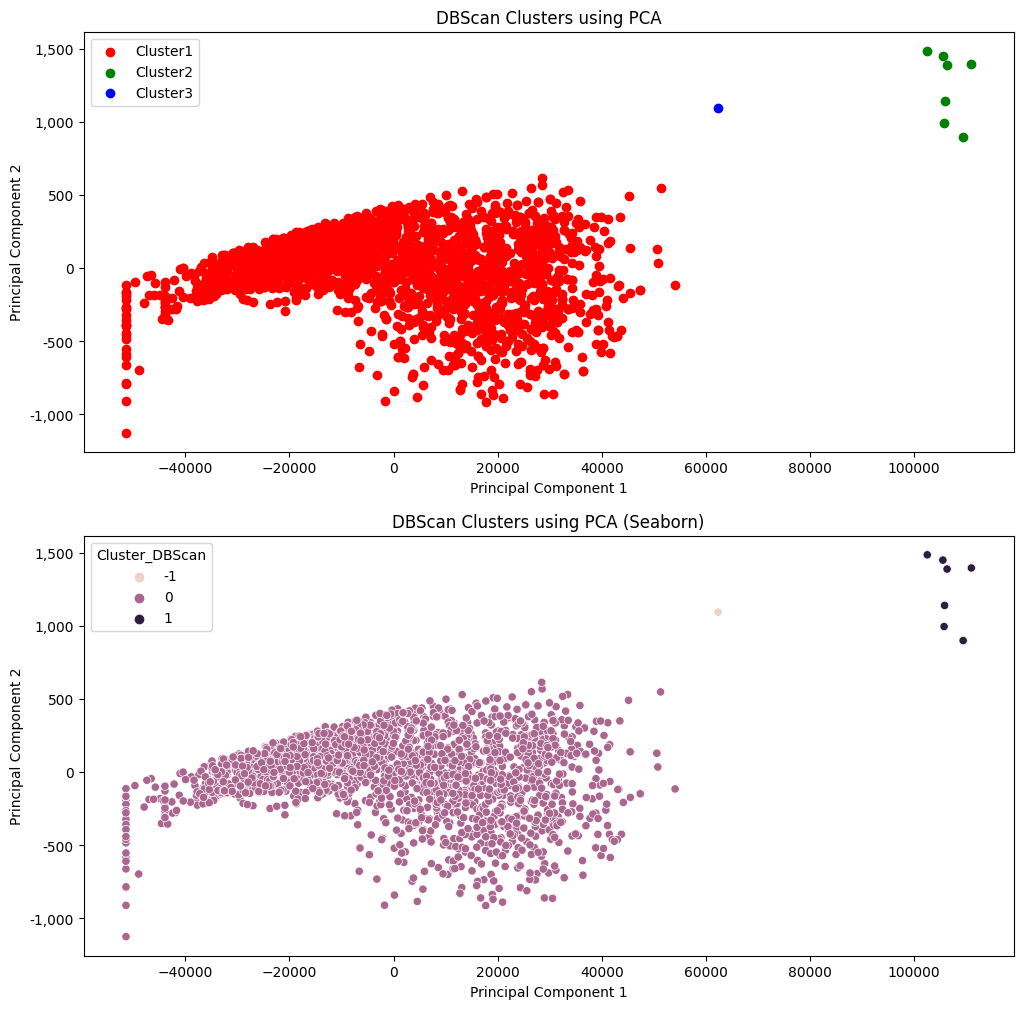

In [130]:
# plot the clusters on a scatter plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))

# plt
ax0.scatter(X[y_pred_dbscan == 0, 0],
            X[y_pred_dbscan == 0, 1], c='r', label='Cluster1')
ax0.scatter(X[y_pred_dbscan == 1, 0],
            X[y_pred_dbscan == 1, 1], c='g', label='Cluster2')
ax0.scatter(X[y_pred_dbscan == -1, 0],
            X[y_pred_dbscan == -1, 1], c='b', label='Cluster3')

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))

ax0.set_title('DBScan Clusters using PCA')
ax0.set_xlabel('Principal Component 1')
ax0.set_ylabel('Principal Component 2')
ax0.legend()

# plot the clusters on a scatter plot using seaborn
ax1 = sns.scatterplot(df_clustering, x='Principal Component 1',
                      y='Principal Component 2', hue='Cluster_DBScan')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda y, pos: '{:,.0f}'.format(y)))
ax1.set_title('DBScan Clusters using PCA (Seaborn)')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

### Cluster Score Comparison

In [131]:
# evaluation by silhouette and davies bouldin scores
# kmeans
sil_score_kmeans = silhouette_score(x, y_pred_kmeans)
db_score_kmeans = davies_bouldin_score(x, y_pred_kmeans)

# evaluation by silhouette and davies bouldin scores
# hierarchical
sil_score_agg = silhouette_score(x, y_pred_agg)
db_score_agg = davies_bouldin_score(x, y_pred_agg)

# evaluation by silhouette and davies bouldin scores
# dbscan
sil_score_dbscan = silhouette_score(x, y_pred_dbscan)
db_score_dbscan = davies_bouldin_score(x, y_pred_dbscan)


headers = ['Silhouette Score', 'Davies Bouldin Score']
tbldata = [
    ['K-Means', sil_score_kmeans, db_score_kmeans],
    ['Hierarchical', sil_score_agg, db_score_agg],
    ['DBScan', sil_score_dbscan, db_score_dbscan]
]

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))

+--------------+--------------------+----------------------+
|              |  Silhouette Score  | Davies Bouldin Score |
+--------------+--------------------+----------------------+
|   K-Means    | 0.5352994983074515 |  0.558171930867513   |
| Hierarchical | 0.5355372019187816 |  0.5534278254666949  |
|    DBScan    | 0.5496759175424317 |  0.2528015317681942  |
+--------------+--------------------+----------------------+
